In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
from sklearn import linear_model
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import confusion_matrix

# read excel file

In [2]:
filePath = 'warfarin.csv'
warfarin = pd.read_csv(filePath)

In [3]:
warfarin.dtypes

PharmGKB Subject ID        object
Gender                     object
Race                       object
Ethnicity                  object
Age                        object
                           ...   
VKORC1 2255 consensus      object
VKORC1 -4451 consensus     object
Unnamed: 63               float64
Unnamed: 64               float64
Unnamed: 65               float64
Length: 66, dtype: object

In [4]:
# remove unnamed columns
warfarin = warfarin.loc[:,~warfarin.columns.str.match("Unnamed")]

## Standard cleaning

In [5]:
warfarin = warfarin[(warfarin['Therapeutic Dose of Warfarin'].notna()) & (warfarin['Age'].notna()) & 
                    (warfarin['Height (cm)'].notna()) & (warfarin['Weight (kg)'].notna()) 
                    & (warfarin['Therapeutic Dose of Warfarin']<310) & (warfarin['Race'].notna()) 
                    & (warfarin['Ethnicity'].notna())]

In [6]:
warfarin = warfarin[warfarin['Subject Reached Stable Dose of Warfarin']==1]

In [7]:
warfarin.shape

(4301, 63)

## standard features

In [8]:
def get_age(x):
    if pd.isna(x):
        return 0
    elif x == '0 - 9':
        return 0
    else:
        x = int(x[0:2])/10
        return x

In [9]:
a = warfarin['VKORC1 genotype: -1639 G>A (3673); chr16:31015190; rs9923231; C/T'].to_numpy()
warfarin['VKORC1AG'] = [1 if elmt == 'A/G' else 0 for elmt in a]
warfarin['VKORC1AA'] = [1 if elmt == 'A/A' else 0 for elmt in a]
warfarin['VKORC1Unknown'] = [1 if elmt not in ('A/G', 'A/A', 'G/G') else 0 for elmt in a]

In [10]:
a = warfarin['Cyp2C9 genotypes'].to_numpy()
warfarin['CYP2C9_12'] = [1 if elmt == '*1/*2' else 0 for elmt in a]
warfarin['CYP2C9_13'] = [1 if elmt == '*1/*3' else 0 for elmt in a]
warfarin['CYP2C9_22'] = [1 if elmt == '*2/*2' else 0 for elmt in a]
warfarin['CYP2C9_23'] = [1 if elmt == '*2/*3' else 0 for elmt in a]
warfarin['CYP2C9_33'] = [1 if elmt == '*3/*3' else 0 for elmt in a]
warfarin['CYP2C9Unknown'] = [1 if elmt not in ('*1/*1', '*1/*3', '*1/*2', '*2/*2', '*2/*3', '*3/*3', '*1/*5',
       '*1/*13', '*1/*14', '*1/*11', '*1/*6') else 0 for elmt in a]

In [11]:
warfarin['Age in decades'] = warfarin['Age'].apply(get_age)
warfarin['Height in cm'] = warfarin['Height (cm)'] #.fillna(0)
warfarin['Weight in kg'] = warfarin['Weight (kg)']
warfarin['Carbamazepine (Tegretol)'] = warfarin['Carbamazepine (Tegretol)'].fillna(0)
warfarin['Amiodarone (Cordarone)'] = warfarin['Amiodarone (Cordarone)'].fillna(0)
warfarin['Phenytoin (Dilantin)'] = warfarin['Phenytoin (Dilantin)'].fillna(0)
warfarin['Rifampin or Rifampicin'] = warfarin['Rifampin or Rifampicin'].fillna(0)
a = warfarin['Race'].to_numpy()
warfarin['Asian race'] = [1 if elmt == 'Asian' else 0 for elmt in a]
warfarin['Black or African American'] = [1 if elmt == 'Black or African American' else 0 for elmt in a]
warfarin['Missing or Mixed race'] = [1 if elmt in ('Mixed', 'Unknown') else 0 for elmt in a]
a = (warfarin['Carbamazepine (Tegretol)']==1) | (warfarin['Phenytoin (Dilantin)']==1) | (warfarin['Rifampin or Rifampicin']==1)
warfarin['Enzyme inducer status'] = [1 if elmt else 0 for elmt in a]
warfarin['Amiodarone status'] = warfarin['Amiodarone (Cordarone)']

In [12]:
warfarin.shape

(4301, 80)

In [147]:
cols = ['Age in decades', 'Height in cm', 'Weight in kg', 'Enzyme inducer status' , 
        'Amiodarone status', 'VKORC1AG', 'VKORC1AA', 'VKORC1Unknown', 'CYP2C9_12', 'CYP2C9_13', 'CYP2C9_22', 
        'CYP2C9_23', 'CYP2C9_33', 'CYP2C9Unknown', 'Asian race', 'Black or African American', 'Missing or Mixed race']
warnearin = warfarin[cols]
warnearout = warfarin['Therapeutic Dose of Warfarin']

In [237]:
warnearin.shape

(4301, 17)

### indication for warfarin treatment

In [14]:
# input: colon separated integers where integers represent a disease/condition that indicates warfarin treatment
# output: return an indicator column for a particular disease
def indicate_war_treatment(x, suffix='DVT'):
    x = str(x)
    y = x.split(';')
    lookup = {'DVT':'1', 'PE':'2', 'Afib':'3', 'HeartValve':'4', 'Cardiomyopathy':'5', 'Stroke':'6', 'PostOrthopedic':'7', 'Other':'8'}
    z = lookup[suffix]
    if z in y:
        return 1
    else:
        return 0

In [13]:
lookup = {'DVT':'1', 'PE':'2', 'Afib':'3', 'HeartValve':'4', 'Cardiomyopathy':'5', 'Stroke':'6', 'PostOrthopedic':'7', 'Other':'8'}
for col in lookup:
    colname = 'IndicationTreatment' + col
    warfarin[colname] = warfarin['Indication for Warfarin Treatment'].apply(lambda x: indicate_war_treatment(x, suffix=col))
    print(warfarin[warfarin[colname].notna()].shape)
    

(4301, 64)
(4301, 65)
(4301, 66)
(4301, 67)
(4301, 68)
(4301, 69)
(4301, 70)
(4301, 71)


In [23]:
warfarin.loc[(warfarin['Valve Replacement']!=1) & (warfarin['IndicationTreatmentHeartValve']==1), ['IndicationTreatmentHeartValve', 'Valve Replacement']].head()

IndicationTreatmentHeartValve  Valve Replacement
1557                              1                0.0
1627                              1                0.0
3475                              1                0.0
4302                              1                0.0

In [29]:
warfarin.loc[(warfarin['Congestive Heart Failure and/or Cardiomyopathy']!=1) & (warfarin['IndicationTreatmentCardiomyopathy']==1), ['IndicationTreatmentCardiomyopathy', 'Congestive Heart Failure and/or Cardiomyopathy']].shape

(2, 2)

In [31]:
warfarin[warfarin['IndicationTreatmentHeartValve'].notna()].shape

(4301, 71)

### target INR

In [7]:
warfarin['Target INR'] = warfarin['Target INR'].fillna(warfarin['Estimated Target INR Range Based on Indication'])

In [8]:
warfarin[warfarin['Target INR'].notna()].shape

(3578, 63)

In [ ]:
#target = warSmall.groupby(['Age', 'Ethnicity', 'Race'], as_index=False)["Target INR"].median()

In [ ]:
def group_prediction(df, col, pred_cols):
    y = df[col]
    X = df.loc[:, pred_cols]
    

In [24]:
def dosage_bucket(x):
    #x = int(x)
    if x<21:
        return "Low"
    elif x<=49:
        return "Medium"
    else:
        return "High"

In [25]:
true_pred = warfarin['Therapeutic Dose of Warfarin'].apply(dosage_bucket)

# Baselines

In [148]:
clinical_pred = ((4.0376 - 0.2546 * warnearin['Age in decades'] + 0.0118 * warnearin['Height in cm'] 
                  + 0.0134 * warnearin['Weight in kg'] - 0.6752 * warnearin['Asian race'] 
                  + 0.4060 * warnearin['Black or African American'] + 0.0443 * warnearin['Missing or Mixed race'] 
                  + 1.2799 * warnearin['Enzyme inducer status'] - 0.5695 * warnearin['Amiodarone status'])**2).apply(dosage_bucket)

In [149]:
pharma_pred = ((5.6044 - 0.2614 * warnearin['Age in decades'] + 0.0087 * warnearin['Height in cm'] 
                  + 0.0128 * warnearin['Weight in kg'] - 0.1092 * warnearin['Asian race'] 
                  - 0.2760 * warnearin['Black or African American'] - 0.1032 * warnearin['Missing or Mixed race'] 
                  + 1.1816 * warnearin['Enzyme inducer status'] - 0.5503 * warnearin['Amiodarone status']
                  - 0.8677 * warnearin['VKORC1AG'] - 1.6974 * warnearin['VKORC1AA'] - 0.4854 * warnearin['VKORC1Unknown']
                  - 0.5211 * warnearin['CYP2C9_12'] - 0.9357 * warnearin['CYP2C9_13'] - 1.0616 * warnearin['CYP2C9_22']
                  - 1.9206 * warnearin['CYP2C9_23'] - 2.3312 * warnearin['CYP2C9_33'] 
                  - 0.2188 * warnearin['CYP2C9Unknown'])**2).apply(dosage_bucket)

In [150]:
fractionFixed = np.zeros((20, m))
regretFixed = np.zeros((20, m))
fractionClinical = np.zeros((20, m))
regretClinical = np.zeros((20, m))
fractionPharma = np.zeros((20, m))
regretPharma = np.zeros((20, m))
#print(fraction.shape, regret)
for k in range(20):
    #print(k)
    totalRegretC = 0
    totalRegretF = 0
    totalRegretP = 0
    totalCorrectC = 0
    totalCorrectP = 0
    totalCorrectF = 0
    np.random.seed(k)
    indices = np.arange(m)
    np.random.shuffle(indices)
    count = 0
    for i in indices:
        count += 1
        # clinical
        if clinical_pred.iloc[i] == true_pred.iloc[i]:
            totalCorrectC += 1
        else:
            totalRegretC += 1
        # pharma
        if pharma_pred.iloc[i] == true_pred.iloc[i]:
            totalCorrectP += 1
        else:
            totalRegretP += 1
        # fixed
        if true_pred.iloc[i] == "Medium":
            totalCorrectF += 1
        else:
            totalRegretF += 1
        
        # update regrets
        regretClinical[k, count-1] = totalRegretC
        regretFixed[k, count-1] = totalRegretF
        regretPharma[k, count-1] = totalRegretP
        # update fractions
        fractionClinical[k, count-1] = totalCorrectC*100.0/count
        fractionFixed[k, count-1] = totalCorrectF*100.0/count
        fractionPharma[k, count-1] = totalCorrectP*100.0/count

In [151]:
cfFixed = confusion_matrix(true_pred, ['Medium']*len(true_pred), labels=['Low', 'Medium', 'High'], normalize='all')
cfFixed

array([[0.        , 0.25807952, 0.        ],
       [0.        , 0.61962334, 0.        ],
       [0.        , 0.12229714, 0.        ]])

In [152]:
cfClinical = confusion_matrix(true_pred, clinical_pred, labels=['Low', 'Medium', 'High'], normalize='all')
cfClinical

array([[9.27691235e-02, 1.64845385e-01, 4.65008138e-04],
       [6.09160660e-02, 5.48942106e-01, 9.76517089e-03],
       [9.30016275e-04, 1.09276912e-01, 1.20902116e-02]])

In [153]:
cfPharma = confusion_matrix(true_pred, pharma_pred, labels=['Low', 'Medium', 'High'], normalize='all')
cfPharma

array([[0.13880493, 0.11834457, 0.00093002],
       [0.08300395, 0.52104162, 0.01557777],
       [0.00093002, 0.08835155, 0.03301558]])

In [154]:
print(fractionFixed[:, -1].mean(), fractionClinical[:, -1].mean(), fractionPharma[:, -1].mean())

61.962334340850965 65.38014415252267 69.28621250871893


# Linear Bandits

## Lin UCB

In [156]:
delta = 0.005
m, n = warnearin.shape
alpha = 1 + np.sqrt(np.log(2/delta)/2)
dosage = ['Low', 'Medium', 'High']
fractionUCB = np.zeros((20, m))
regretUCB = np.zeros((20, m))
cfUCB = np.zeros((20, 3, 3))
#print(fraction.shape, regret)
for k in range(20):
    #print(k)
    totalReward = 0
    totalCorrect = 0
    np.random.seed(k)
    indices = np.arange(m)
    np.random.shuffle(indices)
    count = 0
    A1, A2, A3 = np.eye(n), np.eye(n), np.eye(n)
    b1, b2, b3 = np.zeros((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))
    armChosen = ["Medium"]*m
    for i in indices:
        count += 1
        correct_pred = true_pred.iloc[i] 
        # get feature vector
        row = warnearin.iloc[i, :].values
        row = row[:, np.newaxis]
        # calculate arm 'strengths'
        A1inv, A2inv, A3inv = np.linalg.inv(A1),np.linalg.inv(A2), np.linalg.inv(A3)
        theta1 = np.matmul(A1inv, b1)
        theta2 = np.matmul(A2inv, b2)
        theta3 = np.matmul(A3inv, b3)
        val1 = theta1.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A1inv, row))) 
        val2 = theta2.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A2inv, row)))
        val3 = theta3.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A3inv, row)))
        # choose arm
        j = np.argmax([val1, val2, val3])
        armChosen[i] = dosage[j]
        # reward
        if armChosen[i]==correct_pred:
            r = 0
            totalCorrect += 1
        else:
            r = -1
        # Update A, b
        if j==0:
            A1 += np.matmul(row,row.T)
            b1 += r*row
        elif j==1:
            A2 += np.matmul(row,row.T)
            b2 += r*row
        else:
            A3 += np.matmul(row,row.T)
            b3 += r*row
        totalReward += r
        #print(k, count-1)
        regretUCB[k, count-1] = totalReward*-1
        fractionUCB[k, count-1] = totalCorrect*100.0/count
    cfUCB[k, :, :] = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')

In [157]:
cfUCB.mean(axis=0)

array([[0.11339223, 0.1387468 , 0.00594048],
       [0.07626133, 0.50081376, 0.04254824],
       [0.00240642, 0.09002558, 0.02986515]])

In [158]:
print(fractionUCB[:, -1].mean())

64.40711462450591


In [159]:
delta = 0.0025
m, n = warnearin.shape
alpha = 1 + np.sqrt(np.log(2/delta)/2)
dosage = ['Low', 'Medium', 'High']
fractionUCB2 = np.zeros((20, m))
regretUCB2 = np.zeros((20, m))
cfUCB2 = np.zeros((20, 3, 3))
#print(fraction.shape, regret)
for k in range(20):
    #print(k)
    totalReward = 0
    totalCorrect = 0
    np.random.seed(k)
    indices = np.arange(m)
    np.random.shuffle(indices)
    count = 0
    A1, A2, A3 = np.eye(n), np.eye(n), np.eye(n)
    b1, b2, b3 = np.zeros((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))
    armChosen = ["Medium"]*m
    for i in indices:
        count += 1
        correct_pred = true_pred.iloc[i] 
        # get feature vector
        row = warnearin.iloc[i, :].values
        row = row[:, np.newaxis]
        # calculate arm 'strengths'
        A1inv, A2inv, A3inv = np.linalg.inv(A1),np.linalg.inv(A2), np.linalg.inv(A3)
        theta1 = np.matmul(A1inv, b1)
        theta2 = np.matmul(A2inv, b2)
        theta3 = np.matmul(A3inv, b3)
        val1 = theta1.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A1inv, row))) 
        val2 = theta2.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A2inv, row)))
        val3 = theta3.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A3inv, row)))
        # choose arm
        j = np.argmax([val1, val2, val3])
        armChosen[i] = dosage[j]
        # reward
        if armChosen[i]==correct_pred:
            r = 0
            totalCorrect += 1
        else:
            r = -1
        # Update A, b
        if j==0:
            A1 += np.matmul(row,row.T)
            b1 += r*row
        elif j==1:
            A2 += np.matmul(row,row.T)
            b2 += r*row
        else:
            A3 += np.matmul(row,row.T)
            b3 += r*row
        totalReward += r
        #print(k, count-1)
        regretUCB2[k, count-1] = totalReward*-1
        fractionUCB2[k, count-1] = totalCorrect*100.0/count
    cfUCB2[k, :, :] = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')

In [160]:
cfUCB2.mean(axis=0)

array([[0.11399674, 0.13785166, 0.00623111],
       [0.07755173, 0.4984771 , 0.04359451],
       [0.00245292, 0.08943269, 0.03041153]])

In [161]:
print(fractionUCB2[:, -1].mean())

64.28853754940712


In [162]:
delta = 0.01
m, n = warnearin.shape
alpha = 1 + np.sqrt(np.log(2/delta)/2)
dosage = ['Low', 'Medium', 'High']
fractionUCB3 = np.zeros((20, m))
regretUCB3 = np.zeros((20, m))
cfUCB3 = np.zeros((20, 3, 3))
#print(fraction.shape, regret)
for k in range(20):
    #print(k)
    totalReward = 0
    totalCorrect = 0
    np.random.seed(k)
    indices = np.arange(m)
    np.random.shuffle(indices)
    count = 0
    A1, A2, A3 = np.eye(n), np.eye(n), np.eye(n)
    b1, b2, b3 = np.zeros((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))
    armChosen = ["Medium"]*m
    for i in indices:
        count += 1
        correct_pred = true_pred.iloc[i] 
        # get feature vector
        row = warnearin.iloc[i, :].values
        row = row[:, np.newaxis]
        # calculate arm 'strengths'
        A1inv, A2inv, A3inv = np.linalg.inv(A1),np.linalg.inv(A2), np.linalg.inv(A3)
        theta1 = np.matmul(A1inv, b1)
        theta2 = np.matmul(A2inv, b2)
        theta3 = np.matmul(A3inv, b3)
        val1 = theta1.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A1inv, row))) 
        val2 = theta2.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A2inv, row)))
        val3 = theta3.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A3inv, row)))
        # choose arm
        j = np.argmax([val1, val2, val3])
        armChosen[i] = dosage[j]
        # reward
        if armChosen[i]==correct_pred:
            r = 0
            totalCorrect += 1
        else:
            r = -1
        # Update A, b
        if j==0:
            A1 += np.matmul(row,row.T)
            b1 += r*row
        elif j==1:
            A2 += np.matmul(row,row.T)
            b2 += r*row
        else:
            A3 += np.matmul(row,row.T)
            b3 += r*row
        totalReward += r
        #print(k, count-1)
        regretUCB3[k, count-1] = totalReward*-1
        fractionUCB3[k, count-1] = totalCorrect*100.0/count
    cfUCB3[k, :, :] = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')

In [163]:
cfUCB3.mean(axis=0)

array([[0.11295048, 0.13942106, 0.00570797],
       [0.07527319, 0.50297605, 0.0413741 ],
       [0.00222041, 0.09080446, 0.02927226]])

In [164]:
print(fractionUCB3[:, -1].mean())

64.51987909788421


In [165]:
delta = 0.025
m, n = warnearin.shape
alpha = 1 + np.sqrt(np.log(2/delta)/2)
dosage = ['Low', 'Medium', 'High']
fractionUCB4 = np.zeros((20, m))
regretUCB4 = np.zeros((20, m))
cfUCB4 = np.zeros((20, 3, 3))
#print(fraction.shape, regret)
for k in range(20):
    #print(k)
    totalReward = 0
    totalCorrect = 0
    np.random.seed(k)
    indices = np.arange(m)
    np.random.shuffle(indices)
    count = 0
    A1, A2, A3 = np.eye(n), np.eye(n), np.eye(n)
    b1, b2, b3 = np.zeros((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))
    armChosen = ["Medium"]*m
    for i in indices:
        count += 1
        correct_pred = true_pred.iloc[i] 
        # get feature vector
        row = warnearin.iloc[i, :].values
        row = row[:, np.newaxis]
        # calculate arm 'strengths'
        A1inv, A2inv, A3inv = np.linalg.inv(A1),np.linalg.inv(A2), np.linalg.inv(A3)
        theta1 = np.matmul(A1inv, b1)
        theta2 = np.matmul(A2inv, b2)
        theta3 = np.matmul(A3inv, b3)
        val1 = theta1.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A1inv, row))) 
        val2 = theta2.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A2inv, row)))
        val3 = theta3.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A3inv, row)))
        # choose arm
        j = np.argmax([val1, val2, val3])
        armChosen[i] = dosage[j]
        # reward
        if armChosen[i]==correct_pred:
            r = 0
            totalCorrect += 1
        else:
            r = -1
        # Update A, b
        if j==0:
            A1 += np.matmul(row,row.T)
            b1 += r*row
        elif j==1:
            A2 += np.matmul(row,row.T)
            b2 += r*row
        else:
            A3 += np.matmul(row,row.T)
            b3 += r*row
        totalReward += r
        #print(k, count-1)
        regretUCB4[k, count-1] = totalReward*-1
        fractionUCB4[k, count-1] = totalCorrect*100.0/count
    cfUCB4[k, :, :] = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')

In [166]:
cfUCB4.mean(axis=0)

array([[0.11177633, 0.14067659, 0.0056266 ],
       [0.07291328, 0.50754476, 0.03916531],
       [0.00215066, 0.09219949, 0.02794699]])

In [167]:
print(fractionUCB4[:, -1].mean())

64.7268077191351


In [168]:
delta = 0.1
m, n = warnearin.shape
alpha = 1 + np.sqrt(np.log(2/delta)/2)
dosage = ['Low', 'Medium', 'High']
fractionUCB5 = np.zeros((20, m))
regretUCB5 = np.zeros((20, m))
cfUCB5 = np.zeros((20, 3, 3))
#print(fraction.shape, regret)
for k in range(20):
    #print(k)
    totalReward = 0
    totalCorrect = 0
    np.random.seed(k)
    indices = np.arange(m)
    np.random.shuffle(indices)
    count = 0
    A1, A2, A3 = np.eye(n), np.eye(n), np.eye(n)
    b1, b2, b3 = np.zeros((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))
    armChosen = ["Medium"]*m
    for i in indices:
        count += 1
        correct_pred = true_pred.iloc[i] 
        # get feature vector
        row = warnearin.iloc[i, :].values
        row = row[:, np.newaxis]
        # calculate arm 'strengths'
        A1inv, A2inv, A3inv = np.linalg.inv(A1),np.linalg.inv(A2), np.linalg.inv(A3)
        theta1 = np.matmul(A1inv, b1)
        theta2 = np.matmul(A2inv, b2)
        theta3 = np.matmul(A3inv, b3)
        val1 = theta1.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A1inv, row))) 
        val2 = theta2.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A2inv, row)))
        val3 = theta3.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A3inv, row)))
        # choose arm
        j = np.argmax([val1, val2, val3])
        armChosen[i] = dosage[j]
        # reward
        if armChosen[i]==correct_pred:
            r = 0
            totalCorrect += 1
        else:
            r = -1
        # Update A, b
        if j==0:
            A1 += np.matmul(row,row.T)
            b1 += r*row
        elif j==1:
            A2 += np.matmul(row,row.T)
            b2 += r*row
        else:
            A3 += np.matmul(row,row.T)
            b3 += r*row
        totalReward += r
        #print(k, count-1)
        regretUCB5[k, count-1] = totalReward*-1
        fractionUCB5[k, count-1] = totalCorrect*100.0/count
    cfUCB5[k, :, :] = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')

In [169]:
cfUCB5.mean(axis=0)

array([[0.11075331, 0.14255987, 0.00476633],
       [0.07072774, 0.51252034, 0.03637526],
       [0.00216229, 0.09338526, 0.02674959]])

In [170]:
print(fractionUCB5[:, -1].mean())

65.00232504068822


In [171]:
delta = 0.5
m, n = warnearin.shape
alpha = 1 + np.sqrt(np.log(2/delta)/2)
dosage = ['Low', 'Medium', 'High']
fractionUCB6 = np.zeros((20, m))
regretUCB6 = np.zeros((20, m))
cfUCB6 = np.zeros((20, 3, 3))
#print(fraction.shape, regret)
for k in range(20):
    #print(k)
    totalReward = 0
    totalCorrect = 0
    np.random.seed(k)
    indices = np.arange(m)
    np.random.shuffle(indices)
    count = 0
    A1, A2, A3 = np.eye(n), np.eye(n), np.eye(n)
    b1, b2, b3 = np.zeros((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))
    armChosen = ["Medium"]*m
    for i in indices:
        count += 1
        correct_pred = true_pred.iloc[i] 
        # get feature vector
        row = warnearin.iloc[i, :].values
        row = row[:, np.newaxis]
        # calculate arm 'strengths'
        A1inv, A2inv, A3inv = np.linalg.inv(A1),np.linalg.inv(A2), np.linalg.inv(A3)
        theta1 = np.matmul(A1inv, b1)
        theta2 = np.matmul(A2inv, b2)
        theta3 = np.matmul(A3inv, b3)
        val1 = theta1.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A1inv, row))) 
        val2 = theta2.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A2inv, row)))
        val3 = theta3.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A3inv, row)))
        # choose arm
        j = np.argmax([val1, val2, val3])
        armChosen[i] = dosage[j]
        # reward
        if armChosen[i]==correct_pred:
            r = 0
            totalCorrect += 1
        else:
            r = -1
        # Update A, b
        if j==0:
            A1 += np.matmul(row,row.T)
            b1 += r*row
        elif j==1:
            A2 += np.matmul(row,row.T)
            b2 += r*row
        else:
            A3 += np.matmul(row,row.T)
            b3 += r*row
        totalReward += r
        #print(k, count-1)
        regretUCB6[k, count-1] = totalReward*-1
        fractionUCB6[k, count-1] = totalCorrect*100.0/count
    cfUCB6[k, :, :] = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')

In [172]:
cfUCB6.mean(axis=0)

array([[0.10940479, 0.14466403, 0.0040107 ],
       [0.06679842, 0.52166938, 0.03115555],
       [0.00191816, 0.09587305, 0.02450593]])

In [173]:
print(fractionUCB6[:, -1].mean())

65.55800976517091


In [174]:
delta = 1
m, n = warnearin.shape
alpha = 1 + np.sqrt(np.log(2/delta)/2)
dosage = ['Low', 'Medium', 'High']
fractionUCB7 = np.zeros((20, m))
regretUCB7 = np.zeros((20, m))
cfUCB7 = np.zeros((20, 3, 3))
#print(fraction.shape, regret)
for k in range(20):
    #print(k)
    totalReward = 0
    totalCorrect = 0
    np.random.seed(k)
    indices = np.arange(m)
    np.random.shuffle(indices)
    count = 0
    A1, A2, A3 = np.eye(n), np.eye(n), np.eye(n)
    b1, b2, b3 = np.zeros((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))
    armChosen = ["Medium"]*m
    for i in indices:
        count += 1
        correct_pred = true_pred.iloc[i] 
        # get feature vector
        row = warnearin.iloc[i, :].values
        row = row[:, np.newaxis]
        # calculate arm 'strengths'
        A1inv, A2inv, A3inv = np.linalg.inv(A1),np.linalg.inv(A2), np.linalg.inv(A3)
        theta1 = np.matmul(A1inv, b1)
        theta2 = np.matmul(A2inv, b2)
        theta3 = np.matmul(A3inv, b3)
        val1 = theta1.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A1inv, row))) 
        val2 = theta2.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A2inv, row)))
        val3 = theta3.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A3inv, row)))
        # choose arm
        j = np.argmax([val1, val2, val3])
        armChosen[i] = dosage[j]
        # reward
        if armChosen[i]==correct_pred:
            r = 0
            totalCorrect += 1
        else:
            r = -1
        # Update A, b
        if j==0:
            A1 += np.matmul(row,row.T)
            b1 += r*row
        elif j==1:
            A2 += np.matmul(row,row.T)
            b2 += r*row
        else:
            A3 += np.matmul(row,row.T)
            b3 += r*row
        totalReward += r
        #print(k, count-1)
        regretUCB7[k, count-1] = totalReward*-1
        fractionUCB7[k, count-1] = totalCorrect*100.0/count
    cfUCB7[k, :, :] = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')

In [175]:
cfUCB7.mean(axis=0)

array([[0.10652174, 0.14811672, 0.00344106],
       [0.06396187, 0.52777261, 0.02788886],
       [0.00175541, 0.09894211, 0.02159963]])

In [176]:
print(fractionUCB7[:, -1].mean())

65.58939781446176


# Compare performance

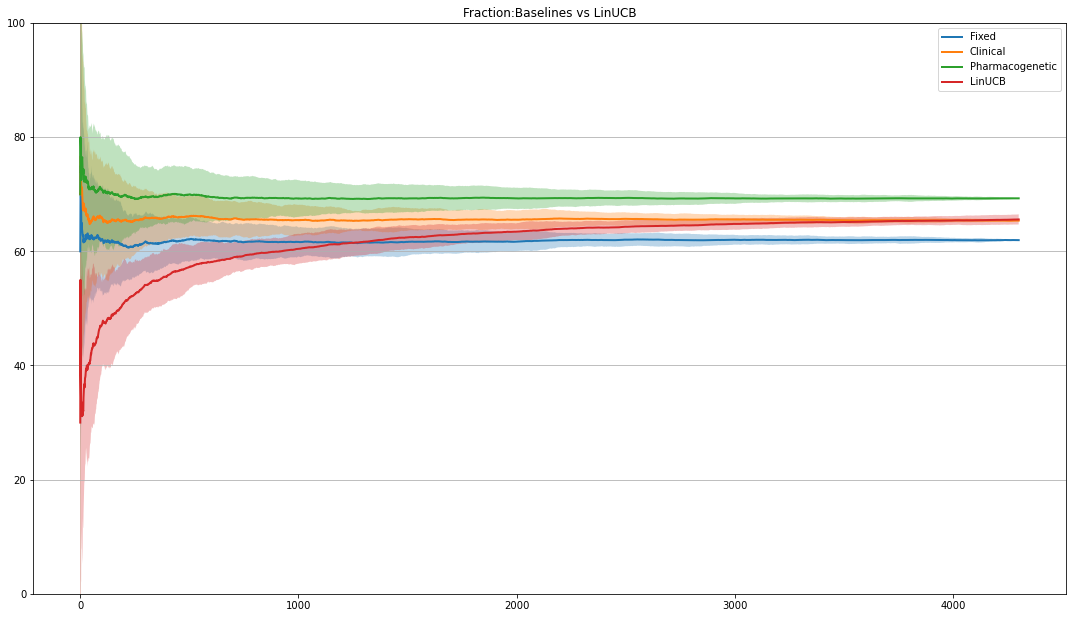

<Figure size 432x288 with 0 Axes>

In [179]:
# plot accuracy/fraction correctly predicted
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
mean_frac_UCB = np.mean(fractionUCB7, axis=0)
dev_frac_UCB = np.std(fractionUCB7, axis=0)
mean_frac_fix = np.mean(fractionFixed, axis=0)
dev_frac_fix = np.std(fractionFixed, axis=0)
mean_frac_cli = np.mean(fractionClinical, axis=0)
dev_frac_cli = np.std(fractionClinical, axis=0)
mean_frac_p = np.mean(fractionPharma, axis=0)
dev_frac_p = np.std(fractionPharma, axis=0)
plt.plot(mean_frac_fix, linewidth=2, label='Fixed')
plt.plot(mean_frac_cli, linewidth=2, label='Clinical')
plt.plot(mean_frac_p, linewidth=2, label='Pharmacogenetic')
plt.plot(mean_frac_UCB, linewidth=2, label='LinUCB')
plt.fill_between(np.arange(len(dev_frac_fix)), (mean_frac_fix-1.96*dev_frac_fix), (mean_frac_fix+1.96*dev_frac_fix), alpha=.3)
plt.fill_between(np.arange(len(dev_frac_fix)), (mean_frac_cli-1.96*dev_frac_cli), (mean_frac_cli+1.96*dev_frac_cli), alpha=.3)
plt.fill_between(np.arange(len(dev_frac_fix)), (mean_frac_p-1.96*dev_frac_p), (mean_frac_p+1.96*dev_frac_p), alpha=.3)
plt.fill_between(np.arange(len(dev_frac_fix)), (mean_frac_UCB-1.96*dev_frac_UCB), (mean_frac_UCB+1.96*dev_frac_UCB), alpha=.3)
plt.legend()
plt.title('Fraction:Baselines vs LinUCB')
plt.ylim((0, 100))
plt.grid(b=True, axis='y')
plt.show()
plt.savefig('FractionBaselinesLinUCB.png')

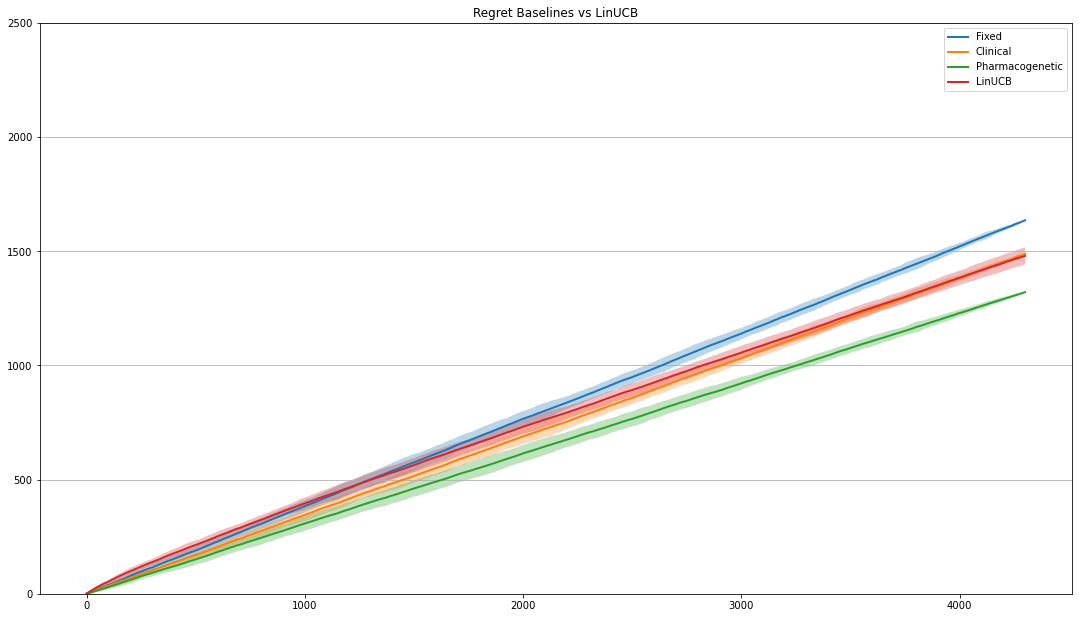

In [180]:
# plot regret
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
mean_frac_UCB = np.mean(regretUCB7, axis=0)
dev_frac_UCB = np.std(regretUCB7, axis=0)
mean_frac_fix = np.mean(regretFixed, axis=0)
dev_frac_fix = np.std(regretFixed, axis=0)
mean_frac_cli = np.mean(regretClinical, axis=0)
dev_frac_cli = np.std(regretClinical, axis=0)
mean_frac_p = np.mean(regretPharma, axis=0)
dev_frac_p = np.std(regretPharma, axis=0)
plt.plot(mean_frac_fix, linewidth=2, label='Fixed')
plt.plot(mean_frac_cli, linewidth=2, label='Clinical')
plt.plot(mean_frac_p, linewidth=2, label='Pharmacogenetic')
plt.plot(mean_frac_UCB, linewidth=2, label='LinUCB')
plt.fill_between(np.arange(len(dev_frac_fix)), (mean_frac_fix-1.96*dev_frac_fix), (mean_frac_fix+1.96*dev_frac_fix), alpha=.3)
plt.fill_between(np.arange(len(dev_frac_fix)), (mean_frac_cli-1.96*dev_frac_cli), (mean_frac_cli+1.96*dev_frac_cli), alpha=.3)
plt.fill_between(np.arange(len(dev_frac_fix)), (mean_frac_p-1.96*dev_frac_p), (mean_frac_p+1.96*dev_frac_p), alpha=.3)
plt.fill_between(np.arange(len(dev_frac_fix)), (mean_frac_UCB-1.96*dev_frac_UCB), (mean_frac_UCB+1.96*dev_frac_UCB), alpha=.3)
plt.legend()
plt.title('Regret Baselines vs LinUCB')
plt.ylim((0, 2500))
plt.grid(b=True, axis='y', which='both')
plt.savefig('RegretBaselinesLinUCB.png')

# Further Directions

## Risk-sensitive reward structure

In [181]:
delta = 1
m, n = warnearin.shape
alpha = 1 + np.sqrt(np.log(2/delta)/2)
dosage = ['Low', 'Medium', 'High']
fractionRisk = np.zeros((20, m))
regretRisk = np.zeros((20, m))
cfRisk = np.zeros((20, 3, 3))
#print(fraction.shape, regret)
for k in range(20):
    #print(k)
    totalReward = 0
    totalCorrect = 0
    np.random.seed(k)
    indices = np.arange(m)
    np.random.shuffle(indices)
    count = 0
    A1, A2, A3 = np.eye(n), np.eye(n), np.eye(n)
    b1, b2, b3 = np.zeros((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))
    armChosen = ["Medium"]*m
    for i in indices:
        count += 1
        correct_pred = true_pred.iloc[i] 
        # get feature vector
        row = warnearin.iloc[i, :].values
        row = row[:, np.newaxis]
        # calculate arm 'strengths'
        A1inv, A2inv, A3inv = np.linalg.inv(A1),np.linalg.inv(A2), np.linalg.inv(A3)
        theta1 = np.matmul(A1inv, b1)
        theta2 = np.matmul(A2inv, b2)
        theta3 = np.matmul(A3inv, b3)
        val1 = theta1.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A1inv, row))) 
        val2 = theta2.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A2inv, row)))
        val3 = theta3.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A3inv, row)))
        # choose arm
        j = np.argmax([val1, val2, val3])
        armChosen[i] = dosage[j]
        # reward
        if armChosen[i]==correct_pred:
            r = 0
            totalCorrect += 1
        else:
            if armChosen[i]=="High":
                r = -10
            else:
                if correct_pred=="High" and armChosen[i]=="Low":
                    r = -5
                else:
                    r = -1
        # Update A, b
        if j==0:
            A1 += np.matmul(row,row.T)
            b1 += r*row
        elif j==1:
            A2 += np.matmul(row,row.T)
            b2 += r*row
        else:
            A3 += np.matmul(row,row.T)
            b3 += r*row
        totalReward += r
        #print(k, count-1)
        regretRisk[k, count-1] = totalReward*-1
        fractionRisk[k, count-1] = totalCorrect*100.0/count
    cfRisk[k, :, :] = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')

In [182]:
cfRisk.mean(axis=0)

array([[8.68518949e-02, 1.71053243e-01, 1.74378052e-04],
       [4.69425715e-02, 5.71797256e-01, 8.83515462e-04],
       [9.99767496e-04, 1.20634736e-01, 6.62636596e-04]])

In [183]:
print(fractionRisk[:, -1].mean())

65.93117879562894


## Thompson Sampling

In [184]:
R = 0.01
delta = 0.01
m, n = warnearin.shape
v = (R**2)*9*n*np.log(m/delta)
fractionTS = np.zeros((20, m))
regretTS = np.zeros((20, m))
cfTS = np.zeros((20, 3, 3))
#print(fraction.shape, regret)
for k in range(20):
    print(k)
    totalReward = 0
    totalCorrect = 0
    indices = np.arange(m)
    np.random.seed(k)
    np.random.shuffle(indices)
    count = 0
    A1, A2, A3 = np.eye(n), np.eye(n), np.eye(n)
    b1, b2, b3 = np.zeros((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))
    armChosen = ["Medium"]*m
    for i in indices:
        count += 1
        correct_pred = true_pred.iloc[i] #truepred['CorrectDose'][i]
        # get feature vector
        row = warnearin.iloc[i, :].values
        row = row[:, np.newaxis]
        # calculate arm 'strengths'
        A1inv, A2inv, A3inv = np.linalg.inv(A1),np.linalg.inv(A2), np.linalg.inv(A3)
        theta1 = np.matmul(A1inv, b1)
        theta2 = np.matmul(A2inv, b2)
        theta3 = np.matmul(A3inv, b3)
        #print(theta1.shape, theta2.shape, theta3.shape)
        pars1 = np.random.multivariate_normal(np.squeeze(theta1), (v*A1inv))
        pars2 = np.random.multivariate_normal(np.squeeze(theta2), (v*A2inv))
        pars3 = np.random.multivariate_normal(np.squeeze(theta3), (v*A3inv))
        #print(pars1.shape, pars2.shape, pars3.shape)
        val1 = pars1.T.dot(row)
        val2 = pars2.T.dot(row)
        val3 = pars3.T.dot(row)
        #print(val1, val2, val3)
        # choose arm
        j = np.argmax([val1, val2, val3])
        #print(j)
        armChosen[i] = dosage[j]
        # reward
        if armChosen[i]==correct_pred:
            r = 0
            totalCorrect += 1
        else:
            r = -1
        # Update A, b
        if j==0:
            A1 += np.matmul(row,row.T)
            b1 += r*row
        elif j==1:
            A2 += np.matmul(row,row.T)
            b2 += r*row
        else:
            A3 += np.matmul(row,row.T)
            b3 += r*row
        totalReward += r
        regretTS[k, count-1] = (totalReward*-1)
        fractionTS[k, count-1] = totalCorrect*100.0/count
    cfTS[k, :, :] = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [185]:
cfTS.mean(axis=0)

array([[0.09296675, 0.16169495, 0.00341781],
       [0.05555685, 0.54758196, 0.01648454],
       [0.00172053, 0.10956754, 0.01100907]])

In [186]:
print(fractionTS[:, -1].mean())

65.1557777261102


In [187]:
R = 0.05
delta = 0.01
m, n = warnearin.shape
v = (R**2)*9*n*np.log(m/delta)
fractionTS2 = np.zeros((20, m))
regretTS2 = np.zeros((20, m))
cfTS2 = np.zeros((20, 3, 3))
#print(fraction.shape, regret)
for k in range(20):
    print(k)
    totalReward = 0
    totalCorrect = 0
    indices = np.arange(m)
    np.random.seed(k)
    np.random.shuffle(indices)
    count = 0
    A1, A2, A3 = np.eye(n), np.eye(n), np.eye(n)
    b1, b2, b3 = np.zeros((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))
    armChosen = ["Medium"]*m
    for i in indices:
        count += 1
        correct_pred = true_pred.iloc[i] #truepred['CorrectDose'][i]
        # get feature vector
        row = warnearin.iloc[i, :].values
        row = row[:, np.newaxis]
        # calculate arm 'strengths'
        A1inv, A2inv, A3inv = np.linalg.inv(A1),np.linalg.inv(A2), np.linalg.inv(A3)
        theta1 = np.matmul(A1inv, b1)
        theta2 = np.matmul(A2inv, b2)
        theta3 = np.matmul(A3inv, b3)
        #print(theta1.shape, theta2.shape, theta3.shape)
        pars1 = np.random.multivariate_normal(np.squeeze(theta1), (v*A1inv))
        pars2 = np.random.multivariate_normal(np.squeeze(theta2), (v*A2inv))
        pars3 = np.random.multivariate_normal(np.squeeze(theta3), (v*A3inv))
        #print(pars1.shape, pars2.shape, pars3.shape)
        val1 = pars1.T.dot(row)
        val2 = pars2.T.dot(row)
        val3 = pars3.T.dot(row)
        #print(val1, val2, val3)
        # choose arm
        j = np.argmax([val1, val2, val3])
        #print(j)
        armChosen[i] = dosage[j]
        # reward
        if armChosen[i]==correct_pred:
            r = 0
            totalCorrect += 1
        else:
            r = -1
        # Update A, b
        if j==0:
            A1 += np.matmul(row,row.T)
            b1 += r*row
        elif j==1:
            A2 += np.matmul(row,row.T)
            b2 += r*row
        else:
            A3 += np.matmul(row,row.T)
            b3 += r*row
        totalReward += r
        regretTS2[k, count-1] = (totalReward*-1)
        fractionTS2[k, count-1] = totalCorrect*100.0/count
    cfTS2[k, :, :] = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [188]:
cfTS2.mean(axis=0)

array([[0.10653336, 0.128691  , 0.02285515],
       [0.12150663, 0.41690305, 0.08121367],
       [0.00990467, 0.08549175, 0.02690072]])

In [189]:
print(fractionTS2[:, -1].mean())

55.033713089979074


In [190]:
R = 0.001
delta = 0.01
m, n = warnearin.shape
v = (R**2)*9*n*np.log(m/delta)
fractionTS3 = np.zeros((20, m))
regretTS3 = np.zeros((20, m))
cfTS3 = np.zeros((20, 3, 3))
#print(fraction.shape, regret)
for k in range(20):
    print(k)
    totalReward = 0
    totalCorrect = 0
    indices = np.arange(m)
    np.random.seed(k)
    np.random.shuffle(indices)
    count = 0
    A1, A2, A3 = np.eye(n), np.eye(n), np.eye(n)
    b1, b2, b3 = np.zeros((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))
    armChosen = ["Medium"]*m
    for i in indices:
        count += 1
        correct_pred = true_pred.iloc[i] #truepred['CorrectDose'][i]
        # get feature vector
        row = warnearin.iloc[i, :].values
        row = row[:, np.newaxis]
        # calculate arm 'strengths'
        A1inv, A2inv, A3inv = np.linalg.inv(A1),np.linalg.inv(A2), np.linalg.inv(A3)
        theta1 = np.matmul(A1inv, b1)
        theta2 = np.matmul(A2inv, b2)
        theta3 = np.matmul(A3inv, b3)
        #print(theta1.shape, theta2.shape, theta3.shape)
        pars1 = np.random.multivariate_normal(np.squeeze(theta1), (v*A1inv))
        pars2 = np.random.multivariate_normal(np.squeeze(theta2), (v*A2inv))
        pars3 = np.random.multivariate_normal(np.squeeze(theta3), (v*A3inv))
        #print(pars1.shape, pars2.shape, pars3.shape)
        val1 = pars1.T.dot(row)
        val2 = pars2.T.dot(row)
        val3 = pars3.T.dot(row)
        #print(val1, val2, val3)
        # choose arm
        j = np.argmax([val1, val2, val3])
        #print(j)
        armChosen[i] = dosage[j]
        # reward
        if armChosen[i]==correct_pred:
            r = 0
            totalCorrect += 1
        else:
            r = -1
        # Update A, b
        if j==0:
            A1 += np.matmul(row,row.T)
            b1 += r*row
        elif j==1:
            A2 += np.matmul(row,row.T)
            b2 += r*row
        else:
            A3 += np.matmul(row,row.T)
            b3 += r*row
        totalReward += r
        regretTS3[k, count-1] = (totalReward*-1)
        fractionTS3[k, count-1] = totalCorrect*100.0/count
    cfTS3[k, :, :] = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [191]:
cfTS3.mean(axis=0)

array([[7.91095094e-02, 1.78435248e-01, 5.34759358e-04],
       [4.00604511e-02, 5.76028831e-01, 3.53406185e-03],
       [7.44013020e-04, 1.18600326e-01, 2.95280167e-03]])

In [192]:
print(fractionTS3[:, -1].mean())

65.80911415949778


In [193]:
R = 0.0001
delta = 0.01
m, n = warnearin.shape
v = (R**2)*9*n*np.log(m/delta)
fractionTS4 = np.zeros((20, m))
regretTS4 = np.zeros((20, m))
cfTS4 = np.zeros((20, 3, 3))
#print(fraction.shape, regret)
for k in range(20):
    print(k)
    totalReward = 0
    totalCorrect = 0
    indices = np.arange(m)
    np.random.seed(k)
    np.random.shuffle(indices)
    count = 0
    A1, A2, A3 = np.eye(n), np.eye(n), np.eye(n)
    b1, b2, b3 = np.zeros((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))
    armChosen = ["Medium"]*m
    for i in indices:
        count += 1
        correct_pred = true_pred.iloc[i] #truepred['CorrectDose'][i]
        # get feature vector
        row = warnearin.iloc[i, :].values
        row = row[:, np.newaxis]
        # calculate arm 'strengths'
        A1inv, A2inv, A3inv = np.linalg.inv(A1),np.linalg.inv(A2), np.linalg.inv(A3)
        theta1 = np.matmul(A1inv, b1)
        theta2 = np.matmul(A2inv, b2)
        theta3 = np.matmul(A3inv, b3)
        #print(theta1.shape, theta2.shape, theta3.shape)
        pars1 = np.random.multivariate_normal(np.squeeze(theta1), (v*A1inv))
        pars2 = np.random.multivariate_normal(np.squeeze(theta2), (v*A2inv))
        pars3 = np.random.multivariate_normal(np.squeeze(theta3), (v*A3inv))
        #print(pars1.shape, pars2.shape, pars3.shape)
        val1 = pars1.T.dot(row)
        val2 = pars2.T.dot(row)
        val3 = pars3.T.dot(row)
        #print(val1, val2, val3)
        # choose arm
        j = np.argmax([val1, val2, val3])
        #print(j)
        armChosen[i] = dosage[j]
        # reward
        if armChosen[i]==correct_pred:
            r = 0
            totalCorrect += 1
        else:
            r = -1
        # Update A, b
        if j==0:
            A1 += np.matmul(row,row.T)
            b1 += r*row
        elif j==1:
            A2 += np.matmul(row,row.T)
            b2 += r*row
        else:
            A3 += np.matmul(row,row.T)
            b3 += r*row
        totalReward += r
        regretTS4[k, count-1] = (totalReward*-1)
        fractionTS4[k, count-1] = totalCorrect*100.0/count
    cfTS4[k, :, :] = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [194]:
cfTS4.mean(axis=0)

array([[0.06999535, 0.18646826, 0.0016159 ],
       [0.04716345, 0.5571495 , 0.01531039],
       [0.0013834 , 0.11390374, 0.00701   ]])

In [195]:
print(fractionTS4[:, -1].mean())

63.415484770983504


In [196]:
R = 0.005
delta = 0.01
m, n = warnearin.shape
v = (R**2)*9*n*np.log(m/delta)
fractionTS5 = np.zeros((20, m))
regretTS5 = np.zeros((20, m))
cfTS5 = np.zeros((20, 3, 3))
#print(fraction.shape, regret)
for k in range(20):
    print(k)
    totalReward = 0
    totalCorrect = 0
    indices = np.arange(m)
    np.random.seed(k)
    np.random.shuffle(indices)
    count = 0
    A1, A2, A3 = np.eye(n), np.eye(n), np.eye(n)
    b1, b2, b3 = np.zeros((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))
    armChosen = ["Medium"]*m
    for i in indices:
        count += 1
        correct_pred = true_pred.iloc[i] #truepred['CorrectDose'][i]
        # get feature vector
        row = warnearin.iloc[i, :].values
        row = row[:, np.newaxis]
        # calculate arm 'strengths'
        A1inv, A2inv, A3inv = np.linalg.inv(A1),np.linalg.inv(A2), np.linalg.inv(A3)
        theta1 = np.matmul(A1inv, b1)
        theta2 = np.matmul(A2inv, b2)
        theta3 = np.matmul(A3inv, b3)
        #print(theta1.shape, theta2.shape, theta3.shape)
        pars1 = np.random.multivariate_normal(np.squeeze(theta1), (v*A1inv))
        pars2 = np.random.multivariate_normal(np.squeeze(theta2), (v*A2inv))
        pars3 = np.random.multivariate_normal(np.squeeze(theta3), (v*A3inv))
        #print(pars1.shape, pars2.shape, pars3.shape)
        val1 = pars1.T.dot(row)
        val2 = pars2.T.dot(row)
        val3 = pars3.T.dot(row)
        #print(val1, val2, val3)
        # choose arm
        j = np.argmax([val1, val2, val3])
        #print(j)
        armChosen[i] = dosage[j]
        # reward
        if armChosen[i]==correct_pred:
            r = 0
            totalCorrect += 1
        else:
            r = -1
        # Update A, b
        if j==0:
            A1 += np.matmul(row,row.T)
            b1 += r*row
        elif j==1:
            A2 += np.matmul(row,row.T)
            b2 += r*row
        else:
            A3 += np.matmul(row,row.T)
            b3 += r*row
        totalReward += r
        regretTS5[k, count-1] = (totalReward*-1)
        fractionTS5[k, count-1] = totalCorrect*100.0/count
    cfTS5[k, :, :] = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [197]:
cfTS5.mean(axis=0)

array([[0.08126017, 0.17521507, 0.00160428],
       [0.04372239, 0.56717043, 0.00873053],
       [0.00088352, 0.11513601, 0.00627761]])

In [198]:
print(fractionTS5[:, -1].mean())

65.47082073936294


#### LinUCB vs TS graphs

## Non-linearity

### Polynomial features

In [199]:
poly = pp.PolynomialFeatures(2)
output_nparray = poly.fit_transform(warnearin)

In [200]:
target_feature_names = poly.get_feature_names(warnearin.columns)

In [201]:
warpoly = pd.DataFrame(output_nparray, columns = target_feature_names)

In [202]:
warpoly.columns

Index(['1', 'Age in decades', 'Height in cm', 'Weight in kg',
       'Enzyme inducer status', 'Amiodarone status', 'VKORC1AG', 'VKORC1AA',
       'VKORC1Unknown', 'CYP2C9_12',
       ...
       'CYP2C9Unknown^2', 'CYP2C9Unknown Asian race',
       'CYP2C9Unknown Black or African American',
       'CYP2C9Unknown Missing or Mixed race', 'Asian race^2',
       'Asian race Black or African American',
       'Asian race Missing or Mixed race', 'Black or African American^2',
       'Black or African American Missing or Mixed race',
       'Missing or Mixed race^2'],
      dtype='object', length=171)

In [203]:
# drop squares of indicator columns
cols = ['Enzyme inducer status^2' , 'Amiodarone status^2', 'VKORC1AG^2', 'VKORC1AA^2', 'VKORC1Unknown^2', 
        'CYP2C9_12^2', 'CYP2C9_13^2', 'CYP2C9_22^2', 'CYP2C9_23^2', 'CYP2C9_33^2', 'CYP2C9Unknown^2', 'Asian race^2', 
        'Black or African American^2', 'Missing or Mixed race^2']
warpoly = warpoly.drop(cols, axis=1, errors='ignore')

In [204]:
warpoly.columns

Index(['1', 'Age in decades', 'Height in cm', 'Weight in kg',
       'Enzyme inducer status', 'Amiodarone status', 'VKORC1AG', 'VKORC1AA',
       'VKORC1Unknown', 'CYP2C9_12',
       ...
       'CYP2C9_33 CYP2C9Unknown', 'CYP2C9_33 Asian race',
       'CYP2C9_33 Black or African American',
       'CYP2C9_33 Missing or Mixed race', 'CYP2C9Unknown Asian race',
       'CYP2C9Unknown Black or African American',
       'CYP2C9Unknown Missing or Mixed race',
       'Asian race Black or African American',
       'Asian race Missing or Mixed race',
       'Black or African American Missing or Mixed race'],
      dtype='object', length=157)

### "Non"-Lin UCB

In [205]:
delta = 1
# dataset rows, features
m, n = warpoly.shape
alpha = 1 + np.sqrt(np.log(2/delta)/2)
dosage = ['Low', 'Medium', 'High']
fractionUCBPoly = np.zeros((20, m))
regretUCBPoly = np.zeros((20, m))
cfUCBPoly = np.zeros((20, 3, 3))
#print(fraction.shape, regret)
for k in range(20):
    #print(k)
    totalReward = 0
    totalCorrect = 0
    np.random.seed(k)
    indices = np.arange(m)
    np.random.shuffle(indices)
    count = 0
    A1, A2, A3 = np.eye(n), np.eye(n), np.eye(n)
    b1, b2, b3 = np.zeros((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))
    armChosen = ["Medium"]*m
    for i in indices:
        count += 1
        correct_pred = true_pred.iloc[i] 
        # get feature vector
        row = warpoly.iloc[i, :].values
        row = row[:, np.newaxis]
        # calculate arm 'strengths'
        A1inv, A2inv, A3inv = np.linalg.inv(A1),np.linalg.inv(A2), np.linalg.inv(A3)
        theta1 = np.matmul(A1inv, b1)
        theta2 = np.matmul(A2inv, b2)
        theta3 = np.matmul(A3inv, b3)
        val1 = theta1.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A1inv, row))) 
        val2 = theta2.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A2inv, row)))
        val3 = theta3.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A3inv, row)))
        # choose arm
        j = np.argmax([val1, val2, val3])
        armChosen[i] = dosage[j]
        # reward
        if armChosen[i]==correct_pred:
            r = 0
            totalCorrect += 1
        else:
            r = -1
        # Update A, b
        if j==0:
            A1 += np.matmul(row,row.T)
            b1 += r*row
        elif j==1:
            A2 += np.matmul(row,row.T)
            b2 += r*row
        else:
            A3 += np.matmul(row,row.T)
            b3 += r*row
        totalReward += r
        #print(k, count-1)
        regretUCBPoly[k, count-1] = totalReward*-1
        fractionUCBPoly[k, count-1] = totalCorrect*100.0/count
    cfUCBPoly[k, :, :] = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')

In [206]:
cfUCBPoly.mean(axis=0)

array([[0.12499419, 0.11913508, 0.01395024],
       [0.09731458, 0.46632179, 0.05598698],
       [0.00814927, 0.07240177, 0.04174611]])

In [207]:
print(fractionUCBPoly[:, -1].mean())

63.306207858637535


# Lasso

In [208]:
def linear_regression(x, y):
    try:
        CXX = np.dot(x.T, x) / x.shape[0]
        CXY = np.dot(x.T, y) / x.shape[0]
        return np.linalg.solve(CXX, CXY).T
    except np.linalg.LinAlgError:
        return LinearRegression(fit_intercept=False).fit(x, y).coef_


class LassoBandit(object):
    def __init__(self, d, lam0, T, K=3):
        #self.rng = rng
        self.K = K
        self.d = d
        self.lam0 = lam0
        self.beta = np.zeros((K, d))
        #self.beta2 = np.zeros(d)
        #self.beta3 = np.zeros(d)
        self.xs1 = np.zeros((T, d))
        self.xs2 = np.zeros((T, d))
        self.xs3 = np.zeros((T, d))
        self.rs1 = []
        self.rs2 = []
        self.rs3 = []
        self.S1 = np.arange(d)
        self.S2 = np.arange(d)
        self.S3 = np.arange(d)

    def choose_action(self, x):
        if len(self.S1) == 0 and len(self.S2)==0 and len(self.S3)==0:
            a = random.randrange(self.K)
        else:
            a = np.argmax([np.dot(x, self.beta[0]), np.dot(x, self.beta[1]), np.dot(x, self.beta[2])])
        if a == 0:
            t = len(self.rs1)
            self.xs1[t, :] = x
        elif a==1:
            t = len(self.rs2)
            self.xs2[t, :] = x
        else:
            t = len(self.rs3)
            self.xs3[t, :] = x
        return a

    def update_beta(self, r, t, a):
        if a == 0:
            self.rs1.append(r)
            xs, rs = self.xs1, self.rs1
        elif a==1:
            self.rs2.append(r)
            xs, rs = self.xs2, self.rs2
        else:
            self.rs3.append(r)
            xs, rs = self.xs3, self.rs3
        #self.rs.append(r)
        t = len(rs)
        lam = self.lam0 * np.sqrt(2 * np.log(t) * np.log(self.d) / t)
        beta = Lasso(alpha=lam, fit_intercept=False).fit(xs[0:t, :], rs).coef_
        S = np.where(np.abs(beta) > 4 * lam)[0]
        if len(S) == 0:
            self.beta[a] = np.zeros(self.d)
            if a == 0:
                self.S1 = S
            elif a==1:
                self.S2 = S
            else:
                self.S3 = S
            return
        for i in range(1):
            beta_cp = np.zeros(self.d)
            beta_cp[S] = beta[S]
            S = np.where(np.abs(beta_cp) > 4 * lam * np.sqrt(len(S)))[0]
            if len(S) == 0:
                self.beta[a] = np.zeros(self.d)
                return
            beta[S] = linear_regression(xs[0:t, S], rs)
            #beta2[a, S] = linear_regression(np.array(self.xs1)[:, S], self.rs1)
        self.beta[a] = np.zeros(self.d)
        self.beta[a, S] = beta[S]
        if a == 0:
            self.S1 = S
        elif a==1:
            self.S2 = S
        else:
            self.S3 = S

In [209]:
# 1 run
m, d = warpoly.shape
lam0 = 0.005 #0.02
dosage = ['Low', 'Medium', 'High']
fractionLB = np.zeros(m)
regretLB = np.zeros(m)
#print(fraction.shape, regret)
totalReward = 0
totalCorrect = 0
np.random.seed(0)
indices = np.arange(m)
np.random.shuffle(indices)
count = 0
agent = LassoBandit(d, lam0, m)
armChosen = ["Medium"]*m
for i in indices:
    count += 1
    correct_pred = true_pred.iloc[i]
    # get feature vector
    row = warpoly.iloc[i, :].values
    #row = row[:, np.newaxis]
    # calculate arm 'strengths'
    action = agent.choose_action(row)
    armChosen[i] = dosage[action]
    # reward
    if armChosen[i]==correct_pred:
        r = 0
        totalCorrect += 1
    else:
        r = -1
    # Update beta
    agent.update_beta(r, count, action)
    totalReward += r
    #print(k, count-1)
    regretLB[count-1] = totalReward*-1
    fractionLB[count-1] = totalCorrect*100.0/count

<ipython-input-208-b2d3c228c029>:58: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  beta = Lasso(alpha=lam, fit_intercept=False).fit(xs[0:t, :], rs).coef_
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-208-b2d3c228c029>:58: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  beta = Lasso(alpha=lam, fit_intercept=False).fit(xs[0:t, :], rs).coef_
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\skl

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8753141980740399, tolerance: 0.0014
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8738931666984808, tolerance: 0.0014
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3391706116103934, tolerance: 0.0015
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.130014097559822, tolerance: 0.0038
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.132411856023133, tolerance: 0.0038
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.153461697952453, tolerance: 0.0038
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.843637814847998, tolerance: 0.0049
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.847036700133811, tolerance: 0.0049
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.913055227162705, tolerance: 0.0049
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.24595246867636, tolerance: 0.006500000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.334106485338275, tolerance: 0.0066
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.34365998832223, tolerance: 0.0066
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.844084735403024, tolerance: 0.0071
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07685896225957661, tolerance: 0.001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08999895633641652, tolerance: 0.0011
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.78318973480372, tolerance: 0.0076
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.801973940774076, tolerance: 0.0076
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.819404769529537, tolerance: 0.0076
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.150839846477773, tolerance: 0.0088
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.176568690559165, tolerance: 0.0088
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.20974725006634, tolerance: 0.0089
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.01715419796722, tolerance: 0.0097
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.17328885812096, tolerance: 0.0098
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.539286844687492, tolerance: 0.0099
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.962670928801852, tolerance: 0.0108
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.974022232266947, tolerance: 0.0108
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.580773022585675, tolerance: 0.0029000000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.789350293006436, tolerance: 0.012
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9992095146253255, tolerance: 0.003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.903231814348935, tolerance: 0.012100000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.15252567956734, tolerance: 0.0037
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.157374642126666, tolerance: 0.0037
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.177534489606121, tolerance: 0.0038
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did n

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.911147014291316, tolerance: 0.013600000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.499308946522632, tolerance: 0.0043
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.924016732156794, tolerance: 0.013600000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.564419060556452, tolerance: 0.006900000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.59142490492502, tolerance: 0.014
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.72715977801756, tolerance: 0.006900000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.689308858398233, tolerance: 0.0078000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.840623762901288, tolerance: 0.0079
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.054717352385078, tolerance: 0.0079
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.051988544488657, tolerance: 0.0088
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.10448480281974, tolerance: 0.0152
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.271564259954218, tolerance: 0.0089
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.841525267151525, tolerance: 0.016300000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.41984490666744, tolerance: 0.0095
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.552051794128765, tolerance: 0.0095
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.96627581390499, tolerance: 0.016800000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.986085811881258, tolerance: 0.010100000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.16930082905768, tolerance: 0.016800000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.53975436842493, tolerance: 0.0173
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.19906985815185, tolerance: 0.010700000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.54937675840519, tolerance: 0.0173
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.558052066254454, tolerance: 0.0181
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.60072357247162, tolerance: 0.0181
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.71313623988919, tolerance: 0.0181
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.65108007397796, tolerance: 0.018500000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.282252209493613, tolerance: 0.0112
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.350110113581497, tolerance: 0.0112
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.35510181875645, tolerance: 0.0118
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.91577660940142, tolerance: 0.019
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.40948853857947, tolerance: 0.0119
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did n

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.37020436804236, tolerance: 0.019700000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.451266727351175, tolerance: 0.019700000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.326607850682986, tolerance: 0.0128
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.49010007151108, tolerance: 0.013000000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.72522695445681, tolerance: 0.02
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.78348020231155, tolerance: 0.02
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obje

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.4631962595899, tolerance: 0.0205
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.75322984810478, tolerance: 0.0206
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.944552864997878, tolerance: 0.013300000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.18981462389567, tolerance: 0.0212
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.21310609546296, tolerance: 0.0212
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.32659886504135, tolerance: 0.0212
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.56751040450104, tolerance: 0.0216
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.78907120999024, tolerance: 0.0217
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.83140236565447, tolerance: 0.014700000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.983622186692756, tolerance: 0.022000000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.806632053140838, tolerance: 0.0158
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.27518783868079, tolerance: 0.0221
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.42388831040775, tolerance: 0.0229
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.48421919450676, tolerance: 0.0229
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.74580600005118, tolerance: 0.023
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did n

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.75500266487387, tolerance: 0.023700000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.76319290858652, tolerance: 0.023700000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.86235225745376, tolerance: 0.023700000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70.58945485620254, tolerance: 0.0246
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.04138181447924, tolerance: 0.017400000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.09430592978138, tolerance: 0.0175
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.40558286628998, tolerance: 0.0252
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.40804929936913, tolerance: 0.0252
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.44066157488763, tolerance: 0.0252
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.35675695369765, tolerance: 0.0257
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.44420473821302, tolerance: 0.0257
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.4611035397162, tolerance: 0.0257
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did n

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.55188605399105, tolerance: 0.0262
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.414762721280944, tolerance: 0.0182
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.6995019739726, tolerance: 0.0262
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.35621472029472, tolerance: 0.027100000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.76170876568587, tolerance: 0.0182
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.36585981914195, tolerance: 0.027100000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.85489506173148, tolerance: 0.0279
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.454616128689967, tolerance: 0.018500000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.9716752193239, tolerance: 0.0279
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.45682666439967, tolerance: 0.0287
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.50846343941429, tolerance: 0.0287
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.51932019224083, tolerance: 0.0287
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.32830094666525, tolerance: 0.029500000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.63867729828448, tolerance: 0.0296
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.70985982164986, tolerance: 0.0296
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.4382243523555, tolerance: 0.019700000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.87232313805667, tolerance: 0.0302
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.89644850928543, tolerance: 0.0302
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.22892877054014, tolerance: 0.031
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.25899444084588, tolerance: 0.031
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.32000295084278, tolerance: 0.031
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.64524422915173, tolerance: 0.0318
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.71690817733277, tolerance: 0.0318
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.80647106165422, tolerance: 0.0318
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.34655352858235, tolerance: 0.0328
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.408982749737106, tolerance: 0.02
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.37388652271993, tolerance: 0.0328
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did n

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.55108247554509, tolerance: 0.0335
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.83283158088744, tolerance: 0.0335
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.86657067049501, tolerance: 0.0335
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.8588278980292, tolerance: 0.0342
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.92629191655898, tolerance: 0.0342
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.71375078960373, tolerance: 0.0204
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.69454854472667, tolerance: 0.035
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.90729277627987, tolerance: 0.0351
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.95733803152493, tolerance: 0.0351
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.54687653605085, tolerance: 0.035500000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.55550807420184, tolerance: 0.035500000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.63477997660006, tolerance: 0.0356
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.33957480426767, tolerance: 0.0367
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.37499034976472, tolerance: 0.0367
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.58056267692987, tolerance: 0.0368
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111.24543762828526, tolerance: 0.037200000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111.27885143595181, tolerance: 0.037200000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.01635878709391, tolerance: 0.0211
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.6914005007653, tolerance: 0.038200000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.81333395928928, tolerance: 0.0383
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.84160670550794, tolerance: 0.0383
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.22963573388317, tolerance: 0.0386
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.51965496500866, tolerance: 0.038700000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.65861896406321, tolerance: 0.038700000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118.37087588933196, tolerance: 0.0393
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.959415365590345, tolerance: 0.0219
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118.40348504199649, tolerance: 0.0393
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.17138537444495, tolerance: 0.0397
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.26202828098169, tolerance: 0.0224
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.20032071389362, tolerance: 0.0397
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.54256427749547, tolerance: 0.0227
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.76293127209887, tolerance: 0.0402
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.77036037389023, tolerance: 0.0402
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123.70567092749022, tolerance: 0.0407
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123.72935713996951, tolerance: 0.0407
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123.93407133667196, tolerance: 0.0408
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127.12228958789899, tolerance: 0.042
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127.15721926748833, tolerance: 0.042
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127.22399447795964, tolerance: 0.042
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.58268689912873, tolerance: 0.0431
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.71354216091082, tolerance: 0.023200000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.6156791264019, tolerance: 0.0431
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132.8824144198282, tolerance: 0.0438
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132.90909063610695, tolerance: 0.0438
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132.960689971298, tolerance: 0.0438
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.56300302248312, tolerance: 0.044700000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.56480629771644, tolerance: 0.044700000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.61766957388386, tolerance: 0.044700000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.94571735056957, tolerance: 0.0454
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 138.01032066646525, tolerance: 0.0454
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 138.0375777318564, tolerance: 0.0454
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139.88629402265775, tolerance: 0.0459
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139.91758145154003, tolerance: 0.0459
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.23770954574572, tolerance: 0.024300000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141.50104036243818, tolerance: 0.0465
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141.72377750471244, tolerance: 0.0466
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141.7539978102971, tolerance: 0.0466
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143.9348425916844, tolerance: 0.047400000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143.9788966377125, tolerance: 0.047400000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144.02927368844047, tolerance: 0.047400000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.28051207094316, tolerance: 0.0478
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.28985954512893, tolerance: 0.0478
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.33353473197155, tolerance: 0.0478
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148.04792496824382, tolerance: 0.0487
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148.06371702388503, tolerance: 0.0487
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.89713562088163, tolerance: 0.0251
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151.0496980582641, tolerance: 0.049600000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151.07144888481156, tolerance: 0.049600000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151.12488396106903, tolerance: 0.049600000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.25402485922393, tolerance: 0.050300000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.21648662445901, tolerance: 0.0256
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.27907400231703, tolerance: 0.050300000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155.8182280754451, tolerance: 0.051300000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155.87300576966624, tolerance: 0.051300000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155.94348017706446, tolerance: 0.051300000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.00501033751175, tolerance: 0.0519
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.640937407576665, tolerance: 0.0262
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.00574623256082, tolerance: 0.0519
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160.689165210925, tolerance: 0.052700000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160.71151892524324, tolerance: 0.052700000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.49109373658313, tolerance: 0.0264
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162.80849314545867, tolerance: 0.0533
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.69238611344593, tolerance: 0.0268
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.77433791703443, tolerance: 0.0268
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164.988104231966, tolerance: 0.0539
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165.04799496003093, tolerance: 0.0539
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.78773642315462, tolerance: 0.027100000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.35249400055756, tolerance: 0.027200000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167.53996360613854, tolerance: 0.0546
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167.8035237677999, tolerance: 0.054700000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169.3781215732, tolerance: 0.055200000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169.42069914552584, tolerance: 0.055200000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169.4514813618379, tolerance: 0.055200000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170.49626749086076, tolerance: 0.0555
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170.52335930497227, tolerance: 0.0555
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170.7570497851297, tolerance: 0.055600000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173.23259904056738, tolerance: 0.056400000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173.47371272471807, tolerance: 0.0565
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173.527827425517, tolerance: 0.0565
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.69554319468605, tolerance: 0.0575
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.9935116824198, tolerance: 0.057600000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176.0176165567635, tolerance: 0.057600000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.6954713999697, tolerance: 0.058
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.72832868957363, tolerance: 0.058
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.79447726089754, tolerance: 0.058
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did n

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.27454919592927, tolerance: 0.0582
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.36420420370212, tolerance: 0.0582
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.41497074581244, tolerance: 0.0582
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 181.23457341447127, tolerance: 0.0587
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014184131707113485, tolerance: 0.0026000000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.3188476732356, tolerance: 0.0285
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183.03370491010108, tolerance: 0.0592
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183.15199374660563, tolerance: 0.059300000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183.18451700686958, tolerance: 0.059300000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.8164348731746, tolerance: 0.059800000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.83050088045215, tolerance: 0.059800000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.95860427377313, tolerance: 0.029
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186.6503753061495, tolerance: 0.0603
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.98851538669254, tolerance: 0.029400000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.19566753849056, tolerance: 0.029500000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188.25380362728583, tolerance: 0.0608
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.68836724259375, tolerance: 0.030100000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.77826264630307, tolerance: 0.030100000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190.0130584519104, tolerance: 0.0614
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190.0268497487854, tolerance: 0.0614
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190.05774953094087, tolerance: 0.0614
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.20789022574235, tolerance: 0.0621
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.30176013975074, tolerance: 0.0621
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.38110344595145, tolerance: 0.0621
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193.94189353382026, tolerance: 0.0626
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.99751305140091, tolerance: 0.031
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.16490398057203, tolerance: 0.031
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did n

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197.03980785470688, tolerance: 0.0636
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197.0675258212927, tolerance: 0.0636
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197.1038967974827, tolerance: 0.0637
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 199.6635185704185, tolerance: 0.0648
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.381434577205056, tolerance: 0.031400000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 199.98690115461085, tolerance: 0.0649
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201.73039312849005, tolerance: 0.06520000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201.9717138647686, tolerance: 0.0653
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202.0749092725598, tolerance: 0.0654
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.68441454895185, tolerance: 0.0659
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.75677895113043, tolerance: 0.0659
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.78165139222926, tolerance: 0.0659
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206.27159763513467, tolerance: 0.0669
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206.37278979235646, tolerance: 0.0669
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206.3995373586488, tolerance: 0.0669
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209.54974747107326, tolerance: 0.0679
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209.57090096828017, tolerance: 0.0679
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.73355456187728, tolerance: 0.0325
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.33723921542736, tolerance: 0.0683
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.38822186234626, tolerance: 0.0683
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.4309156597925, tolerance: 0.0683
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.91380935183501, tolerance: 0.033100000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 214.39311575872023, tolerance: 0.06910000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 214.64709987216494, tolerance: 0.0692
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.74205873938476, tolerance: 0.033600000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216.56173958330447, tolerance: 0.0698
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.00323441114948, tolerance: 0.0337
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.85083778530947, tolerance: 0.0704
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.99469200088933, tolerance: 0.07050000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219.20252307786205, tolerance: 0.07060000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221.6592673595722, tolerance: 0.0716
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221.8535225881296, tolerance: 0.0717
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222.1071603308404, tolerance: 0.0718
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 224.063457374, tolerance: 0.0723
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70.17261134580308, tolerance: 0.0344
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 224.13352162848955, tolerance: 0.0723
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.66418030929938, tolerance: 0.0728
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.92367853727038, tolerance: 0.0729
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226.27209776787163, tolerance: 0.07300000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228.76565457094782, tolerance: 0.0738
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.03845764674082, tolerance: 0.0347
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228.76897539088534, tolerance: 0.0738
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231.64399816503712, tolerance: 0.0745
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.01671038704487, tolerance: 0.0351
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231.69273770303624, tolerance: 0.0745
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 233.8216898308236, tolerance: 0.0753
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 233.88114096685524, tolerance: 0.0753
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.42711643125936, tolerance: 0.0358
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235.69393063078388, tolerance: 0.07590000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235.97865575840694, tolerance: 0.076
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 236.2319821274277, tolerance: 0.0761
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238.58150969806076, tolerance: 0.07680000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238.72792227571904, tolerance: 0.07690000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238.7814375352053, tolerance: 0.07690000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241.25538172172384, tolerance: 0.07740000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241.54799752699444, tolerance: 0.0775
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241.72703001433177, tolerance: 0.0776
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 243.35967549439204, tolerance: 0.0782
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 243.66999084287403, tolerance: 0.07830000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 243.9083676877592, tolerance: 0.0784
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246.13192668834787, tolerance: 0.0791
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246.15737710679844, tolerance: 0.0791
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246.3716988127026, tolerance: 0.0792
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248.98947543830667, tolerance: 0.08020000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249.3357164773063, tolerance: 0.08020000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.1786253037826, tolerance: 0.038
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergen

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252.95122824760082, tolerance: 0.0815
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252.9573640216026, tolerance: 0.0815
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 253.2434499564443, tolerance: 0.0816
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255.12218796414774, tolerance: 0.0823
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255.28297359110408, tolerance: 0.0823
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255.310126744787, tolerance: 0.0823
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257.3564969923048, tolerance: 0.0828
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257.4570763209692, tolerance: 0.0828
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257.5065844091765, tolerance: 0.0828
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259.78310535684767, tolerance: 0.08360000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259.81245519752275, tolerance: 0.08360000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259.8250218107552, tolerance: 0.08360000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261.7086761014623, tolerance: 0.08410000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261.7647224570384, tolerance: 0.08410000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.55080681764656, tolerance: 0.0392
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264.56566835208355, tolerance: 0.085
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264.5655016478442, tolerance: 0.085
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264.64711019858913, tolerance: 0.085
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did n

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267.50526173772846, tolerance: 0.0859
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267.69837583082955, tolerance: 0.08600000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267.76486439757696, tolerance: 0.08600000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 269.2921146863299, tolerance: 0.0863
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.92640326895774, tolerance: 0.0398
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 269.5655116945712, tolerance: 0.0864
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271.7326100820707, tolerance: 0.08710000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271.96953198902975, tolerance: 0.0872
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 272.26800370388673, tolerance: 0.0873
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274.67378481039634, tolerance: 0.0883
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274.8141560636457, tolerance: 0.0884
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274.83783406071035, tolerance: 0.0884
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276.72804008266826, tolerance: 0.08900000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276.7492134924566, tolerance: 0.08900000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277.0028045931349, tolerance: 0.0891
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279.3091250726458, tolerance: 0.0897
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279.323486479562, tolerance: 0.0897
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279.4287154070578, tolerance: 0.0897
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did n

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 281.30187408660294, tolerance: 0.0903
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 281.37593358809204, tolerance: 0.0903
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 281.4082594879771, tolerance: 0.0903
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 284.0065052499267, tolerance: 0.0912
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 284.0324365568445, tolerance: 0.0912
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 284.0532671845947, tolerance: 0.0912
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 287.0176957927108, tolerance: 0.09230000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 287.03365378861645, tolerance: 0.09230000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 287.0656181526567, tolerance: 0.09230000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289.5296665039022, tolerance: 0.09290000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289.60343239356894, tolerance: 0.09290000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289.80176615154784, tolerance: 0.093
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292.3649052537589, tolerance: 0.09390000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.0182679273072, tolerance: 0.0407
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292.67802701179767, tolerance: 0.094
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Ob

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 294.9447556634853, tolerance: 0.0946
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 294.9464179680121, tolerance: 0.0946
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 295.00367199656216, tolerance: 0.0946
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 297.1245036603869, tolerance: 0.0952
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 297.1509706193238, tolerance: 0.0952
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 297.18845190946104, tolerance: 0.0952
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299.55510138354686, tolerance: 0.0961
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299.59704430487864, tolerance: 0.0961
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299.98088691995326, tolerance: 0.09620000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301.89423260448456, tolerance: 0.09680000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301.9719380749588, tolerance: 0.09680000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302.00430963451896, tolerance: 0.09680000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304.60031170738665, tolerance: 0.09770000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304.64158375521714, tolerance: 0.09770000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304.6563335754253, tolerance: 0.09770000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 308.05892745700663, tolerance: 0.099
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.08948298264028, tolerance: 0.0424
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 308.2865391658822, tolerance: 0.09910000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.29001514538633, tolerance: 0.0429
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311.6285940756724, tolerance: 0.1004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311.70921091638377, tolerance: 0.1004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313.6330248237105, tolerance: 0.1009
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313.72020830532887, tolerance: 0.1009
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313.75167343240037, tolerance: 0.1009
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315.6853980511704, tolerance: 0.1015
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315.8916274282387, tolerance: 0.10160000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315.9375321658207, tolerance: 0.10160000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318.86656832210326, tolerance: 0.10250000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318.9164913356376, tolerance: 0.10250000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318.94940411304606, tolerance: 0.10250000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321.1231511196168, tolerance: 0.10300000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.61137440352312, tolerance: 0.0439
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321.15271383653095, tolerance: 0.10300000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323.4409312360229, tolerance: 0.1038
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323.4883227831424, tolerance: 0.1038
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323.5366375998873, tolerance: 0.1038
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325.1538871442859, tolerance: 0.1041
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.55510201686985, tolerance: 0.045000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.57398754380654, tolerance: 0.0451
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327.5715634029458, tolerance: 0.1051
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327.771693049385, tolerance: 0.1052
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327.81859959589457, tolerance: 0.1052
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329.59485970944405, tolerance: 0.10550000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329.8712994028097, tolerance: 0.1056
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329.9096515915867, tolerance: 0.1056
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

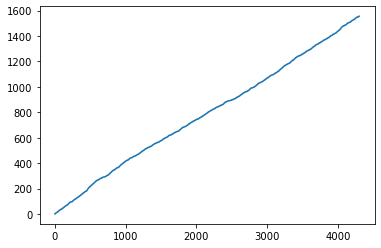

In [210]:
plt.plot(regretLB)
plt.show()

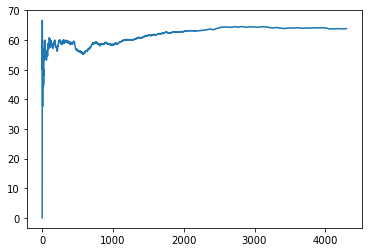

In [211]:
plt.plot(fractionLB)
plt.show()

In [212]:
fractionLB[-1]

63.84561729830272

In [213]:
warpoly.columns[agent.S1]

Index(['1', 'Age in decades', 'Age in decades CYP2C9_13',
       'Age in decades CYP2C9_22', 'Age in decades Asian race',
       'VKORC1AG CYP2C9_13', 'VKORC1AG Black or African American',
       'CYP2C9_13 Asian race'],
      dtype='object')

In [214]:
warpoly.columns[agent.S2]

Index(['Age in decades', 'Age in decades Amiodarone status',
       'Age in decades VKORC1AG', 'Age in decades VKORC1AA',
       'Age in decades VKORC1Unknown', 'Age in decades CYP2C9_12',
       'Age in decades CYP2C9_13', 'Age in decades CYP2C9_23',
       'Age in decades CYP2C9Unknown', 'Amiodarone status VKORC1AG',
       'Amiodarone status Black or African American', 'VKORC1AG CYP2C9_12',
       'VKORC1AG CYP2C9_13', 'VKORC1AG CYP2C9_23',
       'VKORC1AG Black or African American', 'VKORC1AG Missing or Mixed race',
       'VKORC1AA CYP2C9_13', 'VKORC1AA Asian race', 'VKORC1Unknown CYP2C9_12',
       'VKORC1Unknown CYP2C9Unknown', 'CYP2C9_12 Missing or Mixed race'],
      dtype='object')

In [215]:
warpoly.columns[agent.S3]

Index(['Age in decades'], dtype='object')

In [216]:
agent.beta[1]

array([ 0.        , -0.05601057,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.01483631,  0.01825997, -0.03237608,
        0.00946065,  0.02439114, -0.00484798,  0.        , -0.0225978 ,
        0.        ,  0.0007728 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [219]:
agent.beta[0]

array([-1.21486507,  0.09577513,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.01024752,  0.01315359,  0.        ,
        0.        ,  0.        ,  0.02871224,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [220]:
cfLB = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')
cfLB

array([[0.12694722, 0.12741223, 0.00372007],
       [0.1029993 , 0.51081144, 0.0058126 ],
       [0.00325506, 0.11834457, 0.00069751]])

In [221]:
# 1 run
m, d = warpoly.shape
lam0 = 0.01 #0.02
dosage = ['Low', 'Medium', 'High']
fractionLB1 = np.zeros(m)
regretLB1 = np.zeros(m)
#print(fraction.shape, regret)
totalReward = 0
totalCorrect = 0
np.random.seed(0)
indices = np.arange(m)
np.random.shuffle(indices)
count = 0
agent = LassoBandit(d, lam0, m)
armChosen = ["Medium"]*m
for i in indices:
    count += 1
    correct_pred = true_pred.iloc[i]
    # get feature vector
    row = warpoly.iloc[i, :].values
    #row = row[:, np.newaxis]
    # calculate arm 'strengths'
    action = agent.choose_action(row)
    armChosen[i] = dosage[action]
    # reward
    if armChosen[i]==correct_pred:
        r = 0
        totalCorrect += 1
    else:
        r = -1
    # Update beta
    agent.update_beta(r, count, action)
    totalReward += r
    #print(k, count-1)
    regretLB1[count-1] = totalReward*-1
    fractionLB1[count-1] = totalCorrect*100.0/count
cfLB1 = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')

<ipython-input-208-b2d3c228c029>:58: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  beta = Lasso(alpha=lam, fit_intercept=False).fit(xs[0:t, :], rs).coef_
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-208-b2d3c228c029>:58: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  beta = Lasso(alpha=lam, fit_intercept=False).fit(xs[0:t, :], rs).coef_
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\skl

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5110706709179955, tolerance: 0.0016
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.561537010982903, tolerance: 0.0017000000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.566332589109086, tolerance: 0.0018000000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5215276106504625, tolerance: 0.003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.712494822136008, tolerance: 0.003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.772250085162096, tolerance: 0.003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did no

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.423495763420146, tolerance: 0.0049
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.552205657634365, tolerance: 0.005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.601607723194883, tolerance: 0.005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.484656288962027, tolerance: 0.0068000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.739272720126596, tolerance: 0.0068000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.751585831877282, tolerance: 0.0068000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14925756878110663, tolerance: 0.0014
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.112842016114826, tolerance: 0.0074
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15615070917951454, tolerance: 0.0015
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8557035169025116, tolerance: 0.0033
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.16574780086293, tolerance: 0.0079
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.231378343345423, tolerance: 0.0079
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7732160781581212, tolerance: 0.0054
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.16981153330113, tolerance: 0.0089
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.181821158497534, tolerance: 0.0089
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.732435778220783, tolerance: 0.010100000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.741923490599834, tolerance: 0.010100000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.98198683984887, tolerance: 0.010100000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.8123475134222, tolerance: 0.0118
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.10871837505357, tolerance: 0.0118
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.122563168308847, tolerance: 0.0118
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.833887762837744, tolerance: 0.013000000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.964522100436064, tolerance: 0.0131
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.172829387278135, tolerance: 0.0131
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.80396652846955, tolerance: 0.0143
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.853677324586684, tolerance: 0.0143
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.723771228274201, tolerance: 0.0061
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.92555078194373, tolerance: 0.015600000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.04810654466722, tolerance: 0.015600000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.13316903214784, tolerance: 0.015700000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.75845006288187, tolerance: 0.017
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.93655144570533, tolerance: 0.017
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.021037410413356, tolerance: 0.017
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did no

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.414265554546695, tolerance: 0.0181
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.545372144486905, tolerance: 0.0182
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.5569765575371, tolerance: 0.0182
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.989244457260675, tolerance: 0.0193
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.184377500204796, tolerance: 0.0193
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.252622025549144, tolerance: 0.0193
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.667081782481354, tolerance: 0.020900000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.69097416517882, tolerance: 0.020900000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.7074424523214, tolerance: 0.020900000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.89816380330297, tolerance: 0.0218
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.92811707303028, tolerance: 0.0218
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.94911167312163, tolerance: 0.0218
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.6392360802189, tolerance: 0.0227
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.6651485438214, tolerance: 0.0227
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.68779254702877, tolerance: 0.0227
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did no

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.33445512391259, tolerance: 0.0239
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.3780156433745, tolerance: 0.024
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.71902599969447, tolerance: 0.0241
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did no

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.03889033200063, tolerance: 0.0252
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.12792903925126, tolerance: 0.0252
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.2451906120006, tolerance: 0.0253
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did n

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.38460439024213, tolerance: 0.026000000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.41951012770838, tolerance: 0.0261
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.48528895760924, tolerance: 0.0262
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.30151460226384, tolerance: 0.027100000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.56331399276864, tolerance: 0.027200000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.58160034221969, tolerance: 0.027200000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.73160765264659, tolerance: 0.028
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.75531367563579, tolerance: 0.028
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.83368773682264, tolerance: 0.0281
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did no

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.55938327833432, tolerance: 0.029
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3495205679174136, tolerance: 0.0066
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.5767989006321, tolerance: 0.029
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did no

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.93771594324232, tolerance: 0.030100000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.9840920906586, tolerance: 0.030100000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3646623448061055, tolerance: 0.0066
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.12734897413313, tolerance: 0.031
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.15429154070655, tolerance: 0.031
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.18916393093579, tolerance: 0.031
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.37176654676985, tolerance: 0.031900000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.4135462728665, tolerance: 0.031900000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.54331071381021, tolerance: 0.031900000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.5918923515163, tolerance: 0.033100000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.64711158840637, tolerance: 0.0332
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.67022603085283, tolerance: 0.0332
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.99035336711513, tolerance: 0.0345
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.02503815515146, tolerance: 0.0345
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.11959011216247, tolerance: 0.0346
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.24817148317173, tolerance: 0.0357
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.26049583027607, tolerance: 0.0357
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.32109132175272, tolerance: 0.0357
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.08721706159858, tolerance: 0.036500000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.25175399575473, tolerance: 0.0366
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.27402635945013, tolerance: 0.0367
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.57678958448788, tolerance: 0.0375
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.65456693918487, tolerance: 0.0375
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.76540815540766, tolerance: 0.0375
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.7854492465668, tolerance: 0.038400000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.991221719877641, tolerance: 0.007500000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.81866501569439, tolerance: 0.038400000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.08732000597875, tolerance: 0.039400000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.11378214042905, tolerance: 0.039400000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.2241235115306, tolerance: 0.0395
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.2910048243866, tolerance: 0.041
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.37434260170829, tolerance: 0.041100000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.64925720917971, tolerance: 0.0412
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.407949530133555, tolerance: 0.0077
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112.6396040331925, tolerance: 0.0422
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.09509223382571, tolerance: 0.042300000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.29952291490417, tolerance: 0.043300000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.968503373368699, tolerance: 0.0079
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.29939807890167, tolerance: 0.0434
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.43782789687137, tolerance: 0.0443
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.46183871453977, tolerance: 0.0443
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.51238452926145, tolerance: 0.0443
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93457148869686, tolerance: 0.0453
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.07874371153719, tolerance: 0.0454
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.09194263789864, tolerance: 0.0454
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.55946895120186, tolerance: 0.046400000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.59828195087502, tolerance: 0.046400000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.68144668537452, tolerance: 0.046400000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125.26384962024338, tolerance: 0.0472
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125.32122614657726, tolerance: 0.0472
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125.35150446753553, tolerance: 0.0472
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128.04592303381116, tolerance: 0.048400000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128.07922429615047, tolerance: 0.048400000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.088944790015479, tolerance: 0.008
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131.9378221488352, tolerance: 0.049100000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131.95314316161796, tolerance: 0.049100000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131.9906677540786, tolerance: 0.049100000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134.54117985834114, tolerance: 0.050100000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134.58806859740005, tolerance: 0.050100000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134.61670249367052, tolerance: 0.050100000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.81777938521208, tolerance: 0.0511
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.93993415781418, tolerance: 0.0512
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.99685478354226, tolerance: 0.0512
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140.87998317333924, tolerance: 0.052500000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140.93435345592374, tolerance: 0.0526
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141.00577812844966, tolerance: 0.0526
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144.0152842386752, tolerance: 0.0536
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144.0428868011715, tolerance: 0.0536
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144.10635676070913, tolerance: 0.0536
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146.7227476638738, tolerance: 0.0548
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146.98468314427458, tolerance: 0.0548
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146.99314756926196, tolerance: 0.0548
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149.56071516024343, tolerance: 0.0557
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149.599758485825, tolerance: 0.0557
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149.68747020250228, tolerance: 0.0558
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150.78332807735026, tolerance: 0.056100000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003899479924446077, tolerance: 0.0019
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004529836358840845, tolerance: 0.002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151.61582325535508, tolerance: 0.0563
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151.66562707797837, tolerance: 0.056400000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151.711756679496, tolerance: 0.056400000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.62181288301068, tolerance: 0.057100000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.70358189920947, tolerance: 0.0572
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.74885366664049, tolerance: 0.0572
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.657782589490589, tolerance: 0.0088
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155.69731317109475, tolerance: 0.0579
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155.7372316607101, tolerance: 0.058
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.4595923133007, tolerance: 0.0589
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.57375669601487, tolerance: 0.0589
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.6625758162138, tolerance: 0.059000000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162.15653834357016, tolerance: 0.060200000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.992314645674032, tolerance: 0.0089
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162.18486210927674, tolerance: 0.0603
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165.11484524902312, tolerance: 0.061500000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165.36644146852407, tolerance: 0.0616
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165.48659943820377, tolerance: 0.0616
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167.6729841274819, tolerance: 0.062400000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167.82120988315106, tolerance: 0.062400000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167.90299516674318, tolerance: 0.0625
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170.37498602119646, tolerance: 0.0635
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170.4182575692768, tolerance: 0.0636
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170.75605618277405, tolerance: 0.0637
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172.79347170387166, tolerance: 0.0645
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173.05985799863112, tolerance: 0.0646
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173.1493236792296, tolerance: 0.06470000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.7064996250523, tolerance: 0.0655
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.71511359818535, tolerance: 0.0655
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.77232710977316, tolerance: 0.0655
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.99896570340894, tolerance: 0.0663
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178.09135649368002, tolerance: 0.0663
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.525628138835318, tolerance: 0.0097
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180.2645757229951, tolerance: 0.0673
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180.4598517152898, tolerance: 0.0673
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180.5148280807819, tolerance: 0.0674
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 181.83119016969525, tolerance: 0.0679
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 181.83791564068102, tolerance: 0.0679
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 181.8682444274708, tolerance: 0.0679
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.60471668707947, tolerance: 0.06910000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.62218641848747, tolerance: 0.06910000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.174229936868823, tolerance: 0.010100000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.9057215030295, tolerance: 0.0702
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.9387119298718, tolerance: 0.0702
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.9763977043485, tolerance: 0.0702
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190.38819051852732, tolerance: 0.07100000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190.46387152527927, tolerance: 0.07100000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190.51749793730053, tolerance: 0.0711
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.93997379464835, tolerance: 0.0724
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193.21239747553062, tolerance: 0.07250000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193.39273754326283, tolerance: 0.0726
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196.64343944788158, tolerance: 0.0737
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196.7211894382784, tolerance: 0.0737
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196.946074161941, tolerance: 0.0737
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.23315862502213, tolerance: 0.0751
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.26910300500867, tolerance: 0.0751
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.2991266611007, tolerance: 0.0751
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.828773765742994, tolerance: 0.010400000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.836768471749881, tolerance: 0.010400000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202.93435785181163, tolerance: 0.07590000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205.55488269038273, tolerance: 0.07690000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205.9111346311643, tolerance: 0.077
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205.95156229435008, tolerance: 0.077
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208.40178406160598, tolerance: 0.0779
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208.81429391447602, tolerance: 0.078
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208.84682833372187, tolerance: 0.078
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.4648765777913, tolerance: 0.0792
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.51357426766188, tolerance: 0.0792
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.6163642954308, tolerance: 0.07930000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213.20873550143892, tolerance: 0.07980000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213.2806775683564, tolerance: 0.0799
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213.3000313218152, tolerance: 0.0799
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.73453785991197, tolerance: 0.08070000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.8007475923548, tolerance: 0.08070000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.91938131319236, tolerance: 0.08080000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.8402162941735, tolerance: 0.082
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.87806662420772, tolerance: 0.082
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219.23186414430583, tolerance: 0.0821
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221.86868587905406, tolerance: 0.0829
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221.89757104171915, tolerance: 0.0829
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221.90900543194346, tolerance: 0.0829
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223.83017667475355, tolerance: 0.0834
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223.85782256391158, tolerance: 0.0834
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223.87270552246864, tolerance: 0.0834
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.89105856064862, tolerance: 0.08370000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.9000712942214, tolerance: 0.08370000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.94232956872463, tolerance: 0.0838
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227.86045448688193, tolerance: 0.08460000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228.14197288060814, tolerance: 0.0847
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228.161664786701, tolerance: 0.0848
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229.90126369496772, tolerance: 0.0852
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229.90436504414066, tolerance: 0.0853
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230.03692383180638, tolerance: 0.0854
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232.98427708859464, tolerance: 0.0863
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 233.1532076113377, tolerance: 0.0863
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 233.25212854513723, tolerance: 0.0864
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235.4256110449481, tolerance: 0.08710000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235.52748330235602, tolerance: 0.08710000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235.5409248724248, tolerance: 0.08710000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238.10382963441683, tolerance: 0.0881
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238.1118267073375, tolerance: 0.0881
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238.14887495556087, tolerance: 0.0881
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240.78751444940852, tolerance: 0.0891
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.947069251067207, tolerance: 0.012100000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240.97632478705353, tolerance: 0.0891
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 243.44051336978387, tolerance: 0.0901
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 243.5312236410068, tolerance: 0.0901
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 243.54300388647349, tolerance: 0.0901
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246.04227331748797, tolerance: 0.0915
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246.40727232961757, tolerance: 0.0916
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246.42512354408024, tolerance: 0.0916
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249.68414229465137, tolerance: 0.09280000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249.78978560565682, tolerance: 0.09280000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249.88424359013337, tolerance: 0.09290000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252.07484236133232, tolerance: 0.09380000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252.17631107813224, tolerance: 0.09380000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252.54853899367555, tolerance: 0.09380000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254.41424179106698, tolerance: 0.0945
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254.44109364747192, tolerance: 0.0945
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254.57522672739543, tolerance: 0.0946
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257.4326809844504, tolerance: 0.0959
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.790264742431152, tolerance: 0.012400000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257.53863615620315, tolerance: 0.0959
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260.9980870120779, tolerance: 0.09720000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261.1615325080601, tolerance: 0.09720000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261.1969860101087, tolerance: 0.09720000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263.67065664164954, tolerance: 0.098
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.847009830214109, tolerance: 0.0125
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263.9779497150513, tolerance: 0.0981
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266.48335530285397, tolerance: 0.0988
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266.54505674831887, tolerance: 0.0988
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.973042917137787, tolerance: 0.0126
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 269.4460853186841, tolerance: 0.0998
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 269.49679159559105, tolerance: 0.0998
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 269.6421813410734, tolerance: 0.0999
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 272.24002886278237, tolerance: 0.10070000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 272.43146646357656, tolerance: 0.1008
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 272.5843457604878, tolerance: 0.1008
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275.3801590765369, tolerance: 0.10210000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275.45500409224513, tolerance: 0.1022
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275.6700606424018, tolerance: 0.1023
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278.70463587282006, tolerance: 0.1037
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278.88431649758996, tolerance: 0.1038
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278.91017902938023, tolerance: 0.1038
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 281.0799864251044, tolerance: 0.1043
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 281.10547769117386, tolerance: 0.1044
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 281.1138419138848, tolerance: 0.1044
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283.6245485426026, tolerance: 0.1056
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283.7500894825785, tolerance: 0.1056
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 284.05899744954405, tolerance: 0.1057
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 286.33286644726644, tolerance: 0.1067
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 286.44012464712677, tolerance: 0.1067
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 286.4878843643058, tolerance: 0.1067
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289.68513612543285, tolerance: 0.1076
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289.67531186250574, tolerance: 0.1076
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289.7357200628135, tolerance: 0.1076
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292.6111405185796, tolerance: 0.1085
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292.5182583313856, tolerance: 0.1086
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292.5253420245015, tolerance: 0.1086
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 295.025610372132, tolerance: 0.10930000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 295.1566711836532, tolerance: 0.10940000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 295.4733773436498, tolerance: 0.1095
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergen

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299.6088245929124, tolerance: 0.1106
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299.67158774132884, tolerance: 0.1107
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299.81183424164306, tolerance: 0.1107
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302.37969499853864, tolerance: 0.1114
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.81776757796942, tolerance: 0.0134
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302.432524087245, tolerance: 0.1114
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304.96363362852816, tolerance: 0.1125
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304.99114046122065, tolerance: 0.1125
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.07532641106013, tolerance: 0.013600000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307.5133559781724, tolerance: 0.11330000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307.97041088484946, tolerance: 0.1134
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 308.00745358790385, tolerance: 0.1134
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310.8495990833016, tolerance: 0.1144
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310.9224965106387, tolerance: 0.1145
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310.5686387437417, tolerance: 0.1145
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 314.2609116610706, tolerance: 0.11560000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 314.4508348580862, tolerance: 0.11570000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 314.4473523772305, tolerance: 0.11570000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317.9753648654671, tolerance: 0.117
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317.9962457821334, tolerance: 0.117
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318.2915049183421, tolerance: 0.11710000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obj

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320.41083542900674, tolerance: 0.1179
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320.4857986838519, tolerance: 0.1179
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320.7380628369361, tolerance: 0.1179
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322.6423638544692, tolerance: 0.11860000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322.66518330398833, tolerance: 0.11860000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322.70740387921643, tolerance: 0.11860000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325.12675110755504, tolerance: 0.1194
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325.1451605630796, tolerance: 0.1194
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325.3018716340019, tolerance: 0.1194
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327.9141973198719, tolerance: 0.1202
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328.14920146431757, tolerance: 0.1203
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328.1596182112146, tolerance: 0.1203
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330.9755942140453, tolerance: 0.1212
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331.214825409703, tolerance: 0.1213
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331.23463847286035, tolerance: 0.1213
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333.7373694160015, tolerance: 0.1223
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333.7685682596376, tolerance: 0.1223
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333.8964085744587, tolerance: 0.1223
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335.88157190849563, tolerance: 0.1226
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335.9273459611837, tolerance: 0.1226
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335.9187379002086, tolerance: 0.1227
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338.66353550821754, tolerance: 0.1236
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338.74185891461616, tolerance: 0.1236
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338.9665082285952, tolerance: 0.1237
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341.2871655581299, tolerance: 0.1253
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341.3074843694791, tolerance: 0.1253
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341.4455424699121, tolerance: 0.1253
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343.2706238340378, tolerance: 0.1262
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343.36719538718995, tolerance: 0.1262
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343.4842117535134, tolerance: 0.1262
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.33171871383203, tolerance: 0.0149
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345.1636586657558, tolerance: 0.1269
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345.1042882943912, tolerance: 0.1269
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348.422172252829, tolerance: 0.12760000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348.44680808941484, tolerance: 0.12760000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348.4959834723424, tolerance: 0.1277
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351.2033438926122, tolerance: 0.12860000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351.1799118567862, tolerance: 0.12860000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351.3177391545736, tolerance: 0.12860000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354.60303936332383, tolerance: 0.12990000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354.6530546551402, tolerance: 0.13
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354.75357472764205, tolerance: 0.13
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obj

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357.13461579335507, tolerance: 0.1308
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357.37758598911205, tolerance: 0.13090000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357.41501645085265, tolerance: 0.13090000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360.0287583208186, tolerance: 0.1321
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360.18319641828515, tolerance: 0.1321
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360.2195003014144, tolerance: 0.1321
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363.42157778421574, tolerance: 0.133
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363.6266843986747, tolerance: 0.1331
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363.96708411014464, tolerance: 0.1332
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366.68908805632583, tolerance: 0.134
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366.73640474303534, tolerance: 0.134
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366.81084443164315, tolerance: 0.134
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369.27497836702463, tolerance: 0.1351
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369.33705328950975, tolerance: 0.1351
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369.34620159705406, tolerance: 0.1351
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372.13297500130295, tolerance: 0.1361
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372.252251561397, tolerance: 0.1361
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372.28355689582264, tolerance: 0.1361
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375.42813120533896, tolerance: 0.13720000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375.5359833917308, tolerance: 0.13720000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375.53447166877226, tolerance: 0.13720000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 378.81448755146386, tolerance: 0.1388
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379.1602159097787, tolerance: 0.1389
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379.29696383363574, tolerance: 0.1389
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 383.70075927488887, tolerance: 0.1403
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 383.7460595011784, tolerance: 0.1404
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 384.0910069643615, tolerance: 0.1405
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 387.1274414338526, tolerance: 0.1414
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 387.2197912868636, tolerance: 0.14150000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 387.30420499992397, tolerance: 0.14150000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 389.41251205874005, tolerance: 0.1423
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 389.7338328248959, tolerance: 0.1424
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 389.7694056508997, tolerance: 0.1424
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393.220870238446, tolerance: 0.1436
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393.2511547384677, tolerance: 0.1436
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393.2622025924, tolerance: 0.1436
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 395.51906987331466, tolerance: 0.1444
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 395.7946007401563, tolerance: 0.14450000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 395.80801475939813, tolerance: 0.1446
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 398.7600992663813, tolerance: 0.1454
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.612955566563908, tolerance: 0.016
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 398.7988102828765, tolerance: 0.1454
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401.4199199977142, tolerance: 0.1461
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401.5201491024533, tolerance: 0.1461
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401.53395548076725, tolerance: 0.1461
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 404.489531229237, tolerance: 0.1472
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 404.58351733211305, tolerance: 0.14730000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 404.59527445167106, tolerance: 0.14730000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 406.9767026701068, tolerance: 0.1481
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 407.18743223180957, tolerance: 0.1482
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 407.3245166456305, tolerance: 0.1482
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

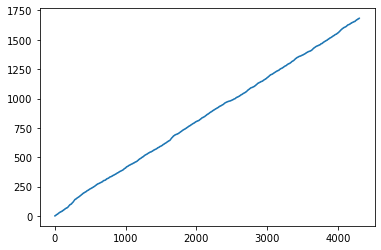

In [224]:
plt.plot(regretLB1)
plt.show()

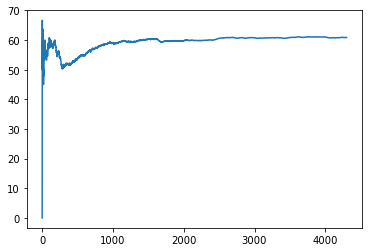

In [225]:
plt.plot(fractionLB1)
plt.show()

In [222]:
fractionLB1[-1]

60.846314810509185

In [223]:
cfLB1

array([[2.97605208e-02, 2.26458963e-01, 1.86003255e-03],
       [3.51081144e-02, 5.78470123e-01, 6.04510579e-03],
       [2.79004883e-03, 1.19274587e-01, 2.32504069e-04]])

In [226]:
warpoly.columns[agent.S1]

Index(['Age in decades', 'Age in decades CYP2C9_13',
       'VKORC1Unknown Asian race'],
      dtype='object')

In [227]:
warpoly.columns[agent.S2]

Index(['Age in decades Amiodarone status', 'Age in decades VKORC1AG',
       'Age in decades VKORC1AA', 'Age in decades VKORC1Unknown',
       'Age in decades CYP2C9_13', 'Age in decades CYP2C9_23',
       'Amiodarone status VKORC1AG', 'VKORC1AG Black or African American'],
      dtype='object')

In [228]:
warpoly.columns[agent.S3]

Index(['Age in decades', 'Age in decades VKORC1AG'], dtype='object')

In [229]:
# 1 run
m, d = warpoly.shape
lam0 = 0.001 #0.02
dosage = ['Low', 'Medium', 'High']
fractionLB2 = np.zeros(m)
regretLB2 = np.zeros(m)
#print(fraction.shape, regret)
totalReward = 0
totalCorrect = 0
np.random.seed(0)
indices = np.arange(m)
np.random.shuffle(indices)
count = 0
agent = LassoBandit(d, lam0, m)
armChosen = ["Medium"]*m
for i in indices:
    count += 1
    correct_pred = true_pred.iloc[i]
    # get feature vector
    row = warpoly.iloc[i, :].values
    #row = row[:, np.newaxis]
    # calculate arm 'strengths'
    action = agent.choose_action(row)
    armChosen[i] = dosage[action]
    # reward
    if armChosen[i]==correct_pred:
        r = 0
        totalCorrect += 1
    else:
        r = -1
    # Update beta
    agent.update_beta(r, count, action)
    totalReward += r
    #print(k, count-1)
    regretLB2[count-1] = totalReward*-1
    fractionLB2[count-1] = totalCorrect*100.0/count
cfLB2 = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')

<ipython-input-208-b2d3c228c029>:58: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  beta = Lasso(alpha=lam, fit_intercept=False).fit(xs[0:t, :], rs).coef_
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-208-b2d3c228c029>:58: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  beta = Lasso(alpha=lam, fit_intercept=False).fit(xs[0:t, :], rs).coef_
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\skl

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033334422904071333, tolerance: 0.0002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.410222738111604, tolerance: 0.0012000000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4164447611881146, tolerance: 0.0012000000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.360295071322679, tolerance: 0.003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.738265097831033, tolerance: 0.0031000000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.87519654571492, tolerance: 0.0032
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.796778706151077, tolerance: 0.0047
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.123001428948141, tolerance: 0.0048000000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.123167045521038, tolerance: 0.0048000000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.08981134859986, tolerance: 0.006200000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.162298511515788, tolerance: 0.006200000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.383523447855449, tolerance: 0.006200000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.503023701041178, tolerance: 0.0068000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.64581958933288, tolerance: 0.006900000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.039144654917604244, tolerance: 0.0012000000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.832174473223457, tolerance: 0.007500000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.86099607597978, tolerance: 0.007500000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8125285993168074, tolerance: 0.0019
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.9846008339487, tolerance: 0.0085
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008098727015499307, tolerance: 0.0016
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.989581978257263, tolerance: 0.0085
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.671373848978607, tolerance: 0.0094
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03013138000191955, tolerance: 0.0019
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.6976847332322, tolerance: 0.0094
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.93700071234815, tolerance: 0.0102
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.302458978259754, tolerance: 0.0103
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.39971327698926, tolerance: 0.0103
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.624421085192143, tolerance: 0.0115
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.631537463025975, tolerance: 0.011600000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.860518112670057, tolerance: 0.0117
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.433554842028826, tolerance: 0.0128
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.447652938660497, tolerance: 0.0128
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0294075783473318, tolerance: 0.0031000000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03627368141620175, tolerance: 0.0026000000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.017306762600879, tolerance: 0.0037
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.735907923392976, tolerance: 0.013600000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.37091037970863, tolerance: 0.014400000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.42369184970451, tolerance: 0.014400000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.434594266470172, tolerance: 0.004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.817410730919995, tolerance: 0.015000000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.88482887410611, tolerance: 0.015000000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.02588688224318, tolerance: 0.0151
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.12839142675254, tolerance: 0.0158
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.186780924344916, tolerance: 0.0158
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.39598577081367, tolerance: 0.0159
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.489522626259343, tolerance: 0.0058000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.651068096438472, tolerance: 0.0059
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.409715281998366, tolerance: 0.016800000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.71106261238527, tolerance: 0.0173
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.87933186510625, tolerance: 0.017400000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.08238145992642, tolerance: 0.0175
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.677126543828496, tolerance: 0.0064
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.39576475036258, tolerance: 0.018000000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.47054476591549, tolerance: 0.018000000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.94832464986034, tolerance: 0.019100000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.98220386602979, tolerance: 0.019100000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.03419604476112, tolerance: 0.019100000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.47098416818865, tolerance: 0.0193
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.48489294890547, tolerance: 0.0193
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.576837978376155, tolerance: 0.0194
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.330120849950255, tolerance: 0.020200000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.227914929451593, tolerance: 0.006900000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.36172305631987, tolerance: 0.020200000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.24065851179689, tolerance: 0.021
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.3113420066357, tolerance: 0.021
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.380804582709544, tolerance: 0.021
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.65158424056294, tolerance: 0.0074
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.695386093360316, tolerance: 0.0074
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.856445713911214, tolerance: 0.021500000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.33973591485752, tolerance: 0.022000000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.562324769948, tolerance: 0.0221
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.858474297270085, tolerance: 0.0222
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.4532990657166, tolerance: 0.0228
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.47707761351515, tolerance: 0.0228
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.620271291219982, tolerance: 0.0078000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.94026363256808, tolerance: 0.023200000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.97929607614479, tolerance: 0.023200000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.01422001708988, tolerance: 0.0233
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.8717253632188, tolerance: 0.0238
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.863652728934813, tolerance: 0.0085
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.93226768717767, tolerance: 0.0238
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.127356950032322, tolerance: 0.0088
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.15544926369024, tolerance: 0.0088
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.59175794163943, tolerance: 0.024900000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.95477201718289, tolerance: 0.0258
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.04727164327286, tolerance: 0.025900000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.06497963230807, tolerance: 0.025900000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.462125459173008, tolerance: 0.009300000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.14159697448297, tolerance: 0.0267
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.466339212841765, tolerance: 0.009300000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.7015112484817, tolerance: 0.0273
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.579879519154098, tolerance: 0.009600000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.77576522754268, tolerance: 0.0273
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.95189524327964, tolerance: 0.0279
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.2201306867577, tolerance: 0.028
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.26200686531622, tolerance: 0.028
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.15563808412914, tolerance: 0.028300000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.47315594717558, tolerance: 0.0284
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.6163717369359, tolerance: 0.0285
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.00787684078121, tolerance: 0.0292
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.24991992528479, tolerance: 0.029300000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.3575331303586, tolerance: 0.029300000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.58398094485266, tolerance: 0.0304
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.60191277604763, tolerance: 0.030500000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.65108072630494, tolerance: 0.030500000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.6638224733769, tolerance: 0.031
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.70046108582778, tolerance: 0.031
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.79195682423074, tolerance: 0.031
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.01805674852982, tolerance: 0.031900000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.04692644181702, tolerance: 0.031900000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.38936293176809, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.53559303452923, tolerance: 0.0327
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.175040453377346, tolerance: 0.011000000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.89642436398066, tolerance: 0.0328
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.56837515046826, tolerance: 0.0332
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.58021578037085, tolerance: 0.0332
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.63502457175645, tolerance: 0.0332
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.69815420715373, tolerance: 0.0339
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.837107961958818, tolerance: 0.0112
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.82553005328555, tolerance: 0.034
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.39837434662445, tolerance: 0.0346
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.43055219816986, tolerance: 0.0346
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.65376649914597, tolerance: 0.0346
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.80038868062051, tolerance: 0.0352
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.93408493887618, tolerance: 0.035300000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.1915008656096, tolerance: 0.0354
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.32967792538762, tolerance: 0.0119
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.01902560195511, tolerance: 0.0361
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.0473533746554, tolerance: 0.0361
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.74967420127352, tolerance: 0.0366
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.76531160175335, tolerance: 0.0366
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.816120433072, tolerance: 0.0366
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.48541950234619, tolerance: 0.0374
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.5014114542448, tolerance: 0.0374
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.56152197256372, tolerance: 0.0374
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.68261942898035, tolerance: 0.0381
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.88727277502358, tolerance: 0.038200000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.90936057274584, tolerance: 0.038200000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.73641628223803, tolerance: 0.0391
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.082480259670447, tolerance: 0.0125
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.84017714039356, tolerance: 0.0391
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.66388464074758, tolerance: 0.039900000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.50720229170683, tolerance: 0.012700000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.9554259987622, tolerance: 0.04
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.652170692343574, tolerance: 0.013000000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.81300616874351, tolerance: 0.040600000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.89277289843093, tolerance: 0.040600000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.06955020359213, tolerance: 0.041100000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.749894056755824, tolerance: 0.0131
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.23324787422516, tolerance: 0.041100000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.80894605576091, tolerance: 0.041600000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.87727475023975, tolerance: 0.041600000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.13186112824624, tolerance: 0.0417
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123.31116873145372, tolerance: 0.042
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123.35283734079039, tolerance: 0.042
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123.41414428943496, tolerance: 0.042
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125.08749755050606, tolerance: 0.0425
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.219151519159507, tolerance: 0.013800000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125.11055302309495, tolerance: 0.0425
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127.21866312209666, tolerance: 0.0432
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127.25750881086606, tolerance: 0.0432
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127.2884179014914, tolerance: 0.0432
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.41627301258487, tolerance: 0.0443
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.67299945251614, tolerance: 0.0444
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.77753891390316, tolerance: 0.0444
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133.65571182362947, tolerance: 0.0454
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134.0049157771162, tolerance: 0.0454
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.41254301041243, tolerance: 0.0143
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.66563693839873, tolerance: 0.0459
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.69534599314122, tolerance: 0.0459
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.73189474204375, tolerance: 0.0459
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.978134137431, tolerance: 0.046700000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 138.16578365705632, tolerance: 0.0468
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.25684489088862, tolerance: 0.0145
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139.40195211047637, tolerance: 0.0472
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139.45635972142637, tolerance: 0.0472
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139.5444463599534, tolerance: 0.0473
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140.94240259371864, tolerance: 0.0477
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.08753385076679, tolerance: 0.015600000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141.02899773802912, tolerance: 0.0477
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142.58792993773793, tolerance: 0.0483
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142.79537457774734, tolerance: 0.048400000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142.82066753257715, tolerance: 0.048400000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144.2258066295734, tolerance: 0.049
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144.42098542278393, tolerance: 0.049100000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144.6154096796549, tolerance: 0.0492
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.82720969495466, tolerance: 0.0495
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.9135746333879, tolerance: 0.049600000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.9157088540127, tolerance: 0.049600000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148.4517921369644, tolerance: 0.0505
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148.4726151378194, tolerance: 0.0505
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148.48555378996286, tolerance: 0.0505
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150.6317580151313, tolerance: 0.051300000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150.67656410586952, tolerance: 0.051300000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151.10274103827336, tolerance: 0.0514
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 152.6876641178852, tolerance: 0.0519
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 152.95830695287498, tolerance: 0.052000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.18424081129072, tolerance: 0.052000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.64282225779635, tolerance: 0.0526
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.91038502847096, tolerance: 0.052700000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.409290393933155, tolerance: 0.0171
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.00864143556478, tolerance: 0.053700000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.2345185541537, tolerance: 0.0538
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.32746299723533, tolerance: 0.0538
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160.36372378908783, tolerance: 0.0545
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160.41204109557012, tolerance: 0.0545
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.875573665860315, tolerance: 0.0177
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162.59848054257816, tolerance: 0.055
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162.8224549028257, tolerance: 0.0551
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.93113042240543, tolerance: 0.0181
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164.30602855012643, tolerance: 0.055400000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.577168301915364, tolerance: 0.0182
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164.35771746709352, tolerance: 0.055400000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166.54663053865377, tolerance: 0.056100000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166.57002519449952, tolerance: 0.056100000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2591202288057186, tolerance: 0.0058000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.7288789354448, tolerance: 0.0568
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.7491428605202, tolerance: 0.0568
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.80176906883371, tolerance: 0.018500000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170.1664150542397, tolerance: 0.057300000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170.2045869762121, tolerance: 0.057300000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170.26041779428272, tolerance: 0.057300000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172.02138556299423, tolerance: 0.057800000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172.03796316565706, tolerance: 0.057800000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172.07076757671132, tolerance: 0.057800000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.11395713567094, tolerance: 0.0589
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.1377398244101, tolerance: 0.0589
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.16188994394238, tolerance: 0.0589
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176.97559002098353, tolerance: 0.0594
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.02761037520105, tolerance: 0.0594
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.25151705791488, tolerance: 0.019200000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178.13810607057164, tolerance: 0.0596
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178.1499184547217, tolerance: 0.0596
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178.19056808351982, tolerance: 0.0596
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180.11516639724448, tolerance: 0.0601
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180.14683160963304, tolerance: 0.0601
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180.16000504544857, tolerance: 0.0601
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 181.98629526770438, tolerance: 0.060700000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182.24448196362493, tolerance: 0.0608
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182.24795295765966, tolerance: 0.0608
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183.57927687318167, tolerance: 0.0613
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.49176403726318, tolerance: 0.020200000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.55451734036711, tolerance: 0.020200000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185.86129146509683, tolerance: 0.0618
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185.90414111045976, tolerance: 0.0618
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186.02504826008084, tolerance: 0.0618
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.04194543348302, tolerance: 0.062
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.23580148175245, tolerance: 0.0621
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.4946952759912, tolerance: 0.020800000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189.29133123609537, tolerance: 0.06280000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189.61944562846898, tolerance: 0.0629
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189.6512338906578, tolerance: 0.0629
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.20711380606295, tolerance: 0.0637
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.24494463969796, tolerance: 0.0637
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.2944143375686, tolerance: 0.0637
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194.0381040259748, tolerance: 0.0641
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194.06737398808815, tolerance: 0.0641
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.50039607567619, tolerance: 0.0216
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196.46665947574223, tolerance: 0.06520000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196.79452667744664, tolerance: 0.0653
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196.8001817679585, tolerance: 0.0653
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 199.92419976868396, tolerance: 0.06620000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.0697544761004, tolerance: 0.0663
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.1056291948599, tolerance: 0.0663
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202.02387550861545, tolerance: 0.0668
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202.0600955482791, tolerance: 0.0668
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202.14743121051214, tolerance: 0.0668
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.77075559317706, tolerance: 0.06720000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.7887030536001, tolerance: 0.06720000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.88669582183766, tolerance: 0.0673
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206.23841607059555, tolerance: 0.0682
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206.25296042257975, tolerance: 0.0682
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206.35088320789194, tolerance: 0.0682
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209.8549547423282, tolerance: 0.0694
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209.88891714152564, tolerance: 0.0694
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210.13695955430973, tolerance: 0.0695
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.4470704077728, tolerance: 0.0698
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.47110209989745, tolerance: 0.0698
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.5253230197082, tolerance: 0.0698
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213.4664132186401, tolerance: 0.0704
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213.5126322950104, tolerance: 0.0704
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213.54607009511156, tolerance: 0.0704
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.80861405174383, tolerance: 0.0712
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.8257704399624, tolerance: 0.0712
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.84712960113174, tolerance: 0.0712
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.45546814570235, tolerance: 0.0719
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.099008144296164, tolerance: 0.023200000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.73869443273486, tolerance: 0.07200000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220.60754930300607, tolerance: 0.0728
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220.65869662730051, tolerance: 0.0728
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220.92330634538794, tolerance: 0.0729
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223.44972217745092, tolerance: 0.07390000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223.746675425829, tolerance: 0.07400000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223.93323043766244, tolerance: 0.0741
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.45822463323228, tolerance: 0.07440000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.46765351089357, tolerance: 0.0745
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.47932629776403, tolerance: 0.0745
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228.11519636406072, tolerance: 0.0753
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228.35142245544233, tolerance: 0.07540000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228.54311107178572, tolerance: 0.0755
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230.3686099415567, tolerance: 0.0761
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230.40518177575322, tolerance: 0.0761
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230.4200061721597, tolerance: 0.0761
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232.4785483818668, tolerance: 0.0767
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232.7657815552987, tolerance: 0.07680000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232.94627260185186, tolerance: 0.07680000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 234.99506755026803, tolerance: 0.0776
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 234.9985741033765, tolerance: 0.0776
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235.18830182071383, tolerance: 0.0777
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237.67667574892297, tolerance: 0.0785
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.16787975439711, tolerance: 0.025400000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237.99604480494415, tolerance: 0.0786
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240.1844626237718, tolerance: 0.0792
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240.29758409161664, tolerance: 0.0792
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.937782826759054, tolerance: 0.0257
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 243.25563217164319, tolerance: 0.0799
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 243.4896901029398, tolerance: 0.08
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 243.5084544757855, tolerance: 0.08
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 245.769310114387, tolerance: 0.08080000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 245.78733354515475, tolerance: 0.08080000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 245.82406339036572, tolerance: 0.08080000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248.01273550053284, tolerance: 0.0815
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248.2600886673876, tolerance: 0.0816
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248.3043984065111, tolerance: 0.0816
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250.84852277371175, tolerance: 0.0826
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250.8807438986925, tolerance: 0.0826
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.289943057118853, tolerance: 0.007200000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254.14717371716122, tolerance: 0.08360000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254.157625146052, tolerance: 0.08360000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.443119072907347, tolerance: 0.007200000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256.41612523185023, tolerance: 0.0844
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.7067397853826725, tolerance: 0.0073
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256.44905865020957, tolerance: 0.0844
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257.7343744184793, tolerance: 0.0848
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.07770879334453, tolerance: 0.027
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257.77051293053705, tolerance: 0.0848
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.70660824082708, tolerance: 0.027100000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259.4225802483863, tolerance: 0.0853
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259.44123706467525, tolerance: 0.0853
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261.14309570370716, tolerance: 0.0857
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261.1599849808203, tolerance: 0.0857
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.918440179939715, tolerance: 0.027600000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263.656059580062, tolerance: 0.08660000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263.8611051710139, tolerance: 0.0867
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264.16584133363517, tolerance: 0.0868
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266.8586596687186, tolerance: 0.0877
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266.90461761979816, tolerance: 0.0877
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266.9358959782119, tolerance: 0.0877
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 268.60592449421944, tolerance: 0.0881
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.08047505577288, tolerance: 0.0281
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 268.6851159520615, tolerance: 0.0881
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271.07924465502066, tolerance: 0.0888
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271.1050156243089, tolerance: 0.0888
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271.1200243250644, tolerance: 0.0888
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 273.8387799762282, tolerance: 0.08990000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 273.8744366742558, tolerance: 0.08990000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.08455561397851, tolerance: 0.0285
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275.81196404591714, tolerance: 0.09050000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.55955837066419, tolerance: 0.0287
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276.1087376674694, tolerance: 0.0906
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278.4593138113327, tolerance: 0.0913
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278.46906756663805, tolerance: 0.0913
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278.5065499825058, tolerance: 0.0913
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280.7273266908305, tolerance: 0.0918
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280.7577263230063, tolerance: 0.0918
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280.76847138394123, tolerance: 0.0918
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 282.542682227771, tolerance: 0.0925
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 282.58046309149813, tolerance: 0.0925
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 282.60041003447867, tolerance: 0.0925
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 284.9522143981842, tolerance: 0.09340000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 285.1609344459998, tolerance: 0.0935
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.51530326327367, tolerance: 0.029
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Ob

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 287.41447568139523, tolerance: 0.094
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 287.45903275864316, tolerance: 0.094
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 287.48495004017866, tolerance: 0.094
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289.98016453113075, tolerance: 0.09480000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290.161526576478, tolerance: 0.0949
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.365630629293254, tolerance: 0.0085
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292.7571546187137, tolerance: 0.0956
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292.8947850721728, tolerance: 0.09570000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292.9359032860413, tolerance: 0.09570000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 295.40304057408, tolerance: 0.0964
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.0558069658248, tolerance: 0.029400000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 295.7291707246929, tolerance: 0.0965
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obj

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 297.7281464576525, tolerance: 0.09720000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298.0192572515034, tolerance: 0.09730000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.97092037178861, tolerance: 0.0296
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299.5464497640166, tolerance: 0.09770000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299.56874115268147, tolerance: 0.09770000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299.64329438451136, tolerance: 0.0978
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303.24474296774446, tolerance: 0.0989
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303.2912037039519, tolerance: 0.0989
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.661019586795949, tolerance: 0.0088
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 305.9811743224767, tolerance: 0.09970000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306.23419109703246, tolerance: 0.0998
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306.4870915683092, tolerance: 0.0999
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309.3587893953838, tolerance: 0.101
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309.69735727113306, tolerance: 0.10110000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.7255124365347, tolerance: 0.030000000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 312.5405256908364, tolerance: 0.10210000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.5035157533172, tolerance: 0.0303
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 312.56118818567217, tolerance: 0.10210000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313.85947372991416, tolerance: 0.1024
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313.8809335507977, tolerance: 0.1024
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.47610362480012, tolerance: 0.0308
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316.7043644149189, tolerance: 0.1034
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316.9563085600528, tolerance: 0.10350000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317.0073399583346, tolerance: 0.10350000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319.0616640675625, tolerance: 0.1039
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.2473261006091, tolerance: 0.031100000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319.07283039745477, tolerance: 0.1039
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321.1152971395094, tolerance: 0.10450000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321.1458610639503, tolerance: 0.10450000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321.1794883408826, tolerance: 0.10450000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323.14674585479713, tolerance: 0.1051
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323.4106258711574, tolerance: 0.1052
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.79857496532755, tolerance: 0.0318
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325.1112871090876, tolerance: 0.10590000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325.15681420814593, tolerance: 0.10590000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325.1880311829541, tolerance: 0.10590000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326.98817282537914, tolerance: 0.10650000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.25106292961947, tolerance: 0.0324
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327.0241437153399, tolerance: 0.10650000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

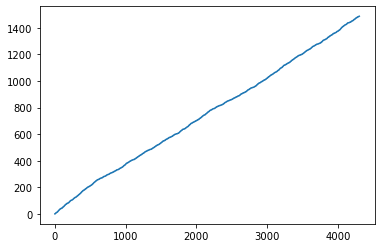

In [230]:
plt.plot(regretLB2)
plt.show()

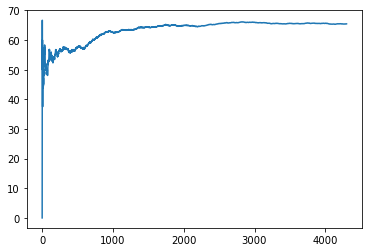

In [231]:
plt.plot(fractionLB2)
plt.show()

In [232]:
fractionLB2[-1]

65.44989537316903

In [233]:
cfLB2

array([[0.11229947, 0.14159498, 0.00418507],
       [0.07323878, 0.52894676, 0.01743781],
       [0.00232504, 0.10671937, 0.01325273]])

In [234]:
warpoly.columns[agent.S1]

Index(['1', 'Age in decades', 'VKORC1AG', 'Asian race',
       'Age in decades Amiodarone status', 'Age in decades VKORC1AG',
       'Age in decades VKORC1AA', 'Age in decades CYP2C9_13',
       'Age in decades CYP2C9_23', 'Age in decades CYP2C9_33',
       'Age in decades CYP2C9Unknown', 'Age in decades Asian race',
       'Height in cm CYP2C9_33', 'Weight in kg Enzyme inducer status',
       'Weight in kg CYP2C9_12', 'Weight in kg CYP2C9_33',
       'Weight in kg Black or African American',
       'Weight in kg Missing or Mixed race', 'Enzyme inducer status CYP2C9_13',
       'Enzyme inducer status CYP2C9Unknown', 'Amiodarone status VKORC1AG',
       'Amiodarone status VKORC1Unknown', 'Amiodarone status CYP2C9_12',
       'Amiodarone status CYP2C9_13', 'Amiodarone status CYP2C9Unknown',
       'Amiodarone status Asian race',
       'Amiodarone status Black or African American', 'VKORC1AG CYP2C9_12',
       'VKORC1AG CYP2C9_13', 'VKORC1AG CYP2C9_23', 'VKORC1AG CYP2C9_33',
       'VKOR

In [235]:
warpoly.columns[agent.S2]

Index(['1', 'Age in decades', 'VKORC1AG', 'VKORC1Unknown', 'Age in decades^2',
       'Age in decades Amiodarone status', 'Age in decades VKORC1AG',
       'Age in decades VKORC1AA', 'Age in decades VKORC1Unknown',
       'Age in decades CYP2C9_12', 'Age in decades CYP2C9_13',
       'Age in decades CYP2C9_23', 'Age in decades CYP2C9Unknown',
       'Age in decades Missing or Mixed race', 'Height in cm CYP2C9_23',
       'Height in cm CYP2C9_33', 'Weight in kg Amiodarone status',
       'Weight in kg VKORC1AA', 'Weight in kg CYP2C9_33',
       'Enzyme inducer status Amiodarone status',
       'Enzyme inducer status VKORC1AA', 'Enzyme inducer status CYP2C9_13',
       'Enzyme inducer status Black or African American',
       'Amiodarone status VKORC1AG', 'Amiodarone status VKORC1AA',
       'Amiodarone status VKORC1Unknown', 'Amiodarone status CYP2C9_12',
       'Amiodarone status CYP2C9_22',
       'Amiodarone status Black or African American',
       'Amiodarone status Missing or Mixe

In [236]:
warpoly.columns[agent.S3]

Index(['1', 'Age in decades', 'Age in decades Enzyme inducer status',
       'Age in decades Amiodarone status', 'Age in decades VKORC1AG',
       'Age in decades VKORC1AA', 'Age in decades VKORC1Unknown',
       'Age in decades CYP2C9_12', 'Age in decades CYP2C9_13',
       'Age in decades CYP2C9_22', 'Age in decades CYP2C9_23',
       'Age in decades CYP2C9Unknown', 'Age in decades Asian race',
       'Age in decades Black or African American',
       'Age in decades Missing or Mixed race',
       'Height in cm Missing or Mixed race', 'Weight in kg Amiodarone status',
       'Weight in kg CYP2C9_13', 'Weight in kg Missing or Mixed race',
       'Enzyme inducer status VKORC1AG', 'Enzyme inducer status VKORC1Unknown',
       'Enzyme inducer status CYP2C9_12',
       'Enzyme inducer status Black or African American',
       'Amiodarone status Black or African American', 'VKORC1AG Asian race',
       'VKORC1AG Black or African American', 'VKORC1AG Missing or Mixed race',
       'VKORC1AA

### Optimistic Lasso

In [76]:
def linear_regression(x, y):
    try:
        CXX = np.dot(x.T, x) / x.shape[0]
        CXY = np.dot(x.T, y) / x.shape[0]
        return np.linalg.solve(CXX, CXY).T
    except np.linalg.LinAlgError:
        return LinearRegression(fit_intercept=False).fit(x, y).coef_


class LassoBanditOpt(object):
    def __init__(self, d, lam0, T, K=3):
        #self.rng = rng
        self.K = K
        self.d = d
        self.lam0 = lam0
        self.beta = np.zeros((K, d))
        #self.beta2 = np.zeros(d)
        #self.beta3 = np.zeros(d)
        self.xs1 = np.zeros((T, d))
        self.xs2 = np.zeros((T, d))
        self.xs3 = np.zeros((T, d))
        self.rs1 = []
        self.rs2 = []
        self.rs3 = []
        self.S1 = np.arange(d)
        self.S2 = np.arange(d)
        self.S3 = np.arange(d)

    def choose_action(self, x):
        if len(self.S1) == 0 and len(self.S2)==0 and len(self.S3)==0:
            a = random.randrange(self.K)
        else:
            t1 = len(self.rs1)
            lam1 = self.lam0 * np.sqrt(2 * np.log(t1) * np.log(self.d) / t1)
            t2 = len(self.rs2)
            lam2 = self.lam0 * np.sqrt(2 * np.log(t2) * np.log(self.d) / t2)
            t3 = len(self.rs3)
            lam3 = self.lam0 * np.sqrt(2 * np.log(t3) * np.log(self.d) / t3)
            a = np.argmax([np.dot(x, self.beta[0])+2*lam1, np.dot(x, self.beta[1])+2*lam2, np.dot(x, self.beta[2])+2*lam3])
        if a == 0:
            t = len(self.rs1)
            self.xs1[t, :] = x
        elif a==1:
            t = len(self.rs2)
            self.xs2[t, :] = x
        else:
            t = len(self.rs3)
            self.xs3[t, :] = x
        return a

    def update_beta(self, r, t, a):
        if a == 0:
            self.rs1.append(r)
            xs, rs = self.xs1, self.rs1
        elif a==1:
            self.rs2.append(r)
            xs, rs = self.xs2, self.rs2
        else:
            self.rs3.append(r)
            xs, rs = self.xs3, self.rs3
        #self.rs.append(r)
        t = len(rs)
        lam = self.lam0 * np.sqrt(2 * np.log(t) * np.log(self.d) / t)
        beta = Lasso(alpha=lam, fit_intercept=False).fit(xs[0:t, :], rs).coef_
        S = np.where(np.abs(beta) > 4 * lam)[0]
        if len(S) == 0:
            self.beta[a] = np.zeros(self.d)
            if a == 0:
                self.S1 = S
            elif a==1:
                self.S2 = S
            else:
                self.S3 = S
            return
        for i in range(1):
            beta_cp = np.zeros(self.d)
            beta_cp[S] = beta[S]
            S = np.where(np.abs(beta_cp) > 4 * lam * np.sqrt(len(S)))[0]
            if len(S) == 0:
                self.beta[a] = np.zeros(self.d)
                return
            beta[S] = linear_regression(xs[0:t, S], rs)
            #beta2[a, S] = linear_regression(np.array(self.xs1)[:, S], self.rs1)
        self.beta[a] = np.zeros(self.d)
        self.beta[a, S] = beta[S]
        if a == 0:
            self.S1 = S
        elif a==1:
            self.S2 = S
        else:
            self.S3 = S

In [85]:
# LBOptimistic, 1 run
m, d = warpoly.shape
lam0 = 0.0025 #0.02
dosage = ['Low', 'Medium', 'High']
fractionLBO = np.zeros(m)
regretLBO = np.zeros(m)
#print(fraction.shape, regret)
totalReward = 0
totalCorrect = 0
np.random.seed(0)
indices = np.arange(m)
np.random.shuffle(indices)
count = 0
agent = LassoBanditOpt(d, lam0, m)
for i in indices:
    count += 1
    correct_pred = true_pred.iloc[i]
    # get feature vector
    row = warpoly.iloc[i, :].values
    #row = row[:, np.newaxis]
    # calculate arm 'strengths'
    action = agent.choose_action(row)
    armChosen = dosage[action]
    # reward
    if armChosen==correct_pred:
        r = 0
        totalCorrect += 1
    else:
        r = -1
    # Update beta
    agent.update_beta(r, count, action)
    totalReward += r
    #print(k, count-1)
    regretLBO[count-1] = totalReward*-1
    fractionLBO[count-1] = totalCorrect*100.0/count

<ipython-input-76-223c7cf0a664>:34: RuntimeWarning: divide by zero encountered in log
  lam1 = self.lam0 * np.sqrt(2 * np.log(t1) * np.log(self.d) / t1)
<ipython-input-76-223c7cf0a664>:34: RuntimeWarning: invalid value encountered in sqrt
  lam1 = self.lam0 * np.sqrt(2 * np.log(t1) * np.log(self.d) / t1)
<ipython-input-76-223c7cf0a664>:36: RuntimeWarning: divide by zero encountered in log
  lam2 = self.lam0 * np.sqrt(2 * np.log(t2) * np.log(self.d) / t2)
<ipython-input-76-223c7cf0a664>:36: RuntimeWarning: invalid value encountered in sqrt
  lam2 = self.lam0 * np.sqrt(2 * np.log(t2) * np.log(self.d) / t2)
<ipython-input-76-223c7cf0a664>:38: RuntimeWarning: divide by zero encountered in log
  lam3 = self.lam0 * np.sqrt(2 * np.log(t3) * np.log(self.d) / t3)
<ipython-input-76-223c7cf0a664>:38: RuntimeWarning: invalid value encountered in sqrt
  lam3 = self.lam0 * np.sqrt(2 * np.log(t3) * np.log(self.d) / t3)
<ipython-input-76-223c7cf0a664>:64: UserWarning: With alpha=0, this algorithm does

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.966495329001372, tolerance: 0.0019
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.094160631811012, tolerance: 0.0019
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2352496043038941, tolerance: 0.0005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5249697939821552, tolerance: 0.0016
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6959581551837031, tolerance: 0.0016
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.132660435415008, tolerance: 0.0027
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.972513127766405, tolerance: 0.004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.006654014520825, tolerance: 0.004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.006800846080803, tolerance: 0.004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9844901242091849, tolerance: 0.002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.593406623667745, tolerance: 0.0059
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9879836556266867, tolerance: 0.0021000000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0358538131045276, tolerance: 0.0026000000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.27063610289548, tolerance: 0.0068000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.282975066259137, tolerance: 0.0068000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.525868371083362, tolerance: 0.0077
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.589458714109412, tolerance: 0.0077
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.84316249136065, tolerance: 0.0078000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.674451425168684, tolerance: 0.0094
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.844544919596604, tolerance: 0.0095
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.875559006326476, tolerance: 0.0095
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.436810585323563, tolerance: 0.010700000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.47908095049558, tolerance: 0.010700000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.499439008512415, tolerance: 0.010700000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.934182154742317, tolerance: 0.012
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.006950073406877, tolerance: 0.012
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.24931422566528, tolerance: 0.012100000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.43183364112984, tolerance: 0.0134
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1672104780289287, tolerance: 0.0036000000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.60454667082566, tolerance: 0.0134
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.97474847922926, tolerance: 0.0143
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.14642160901819, tolerance: 0.014400000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.40815602677057, tolerance: 0.0145
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5586183545781807, tolerance: 0.004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.95623024727971, tolerance: 0.015600000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.0647368492115, tolerance: 0.015700000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.448504436177615, tolerance: 0.0167
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.47073350448872, tolerance: 0.0167
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.49673695287025, tolerance: 0.0167
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.81507100112291, tolerance: 0.0178
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0570751159618563, tolerance: 0.0043
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.85780734327197, tolerance: 0.0178
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.6401072525589, tolerance: 0.019
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.67514660387848, tolerance: 0.019
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.71810747781043, tolerance: 0.019
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.872896653303325, tolerance: 0.005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.512475413786085, tolerance: 0.0201
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.53964587416946, tolerance: 0.0201
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.52155559113066, tolerance: 0.0206
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.56929446280906, tolerance: 0.0206
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.682418041892085, tolerance: 0.0053
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.35285662067974, tolerance: 0.0211
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.490195564846836, tolerance: 0.0212
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.51557049487541, tolerance: 0.0212
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.52616624312273, tolerance: 0.0222
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.89187011401786, tolerance: 0.0055000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.8950961293346555, tolerance: 0.0055000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.532090355705265, tolerance: 0.022600000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.5598308499595, tolerance: 0.022600000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.62364274094287, tolerance: 0.022600000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.04746179044022, tolerance: 0.0235
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.08670780862978, tolerance: 0.0235
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.0979904560101, tolerance: 0.0235
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did n

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.37001261452875, tolerance: 0.0241
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.3950065068908, tolerance: 0.0241
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.52049302407855, tolerance: 0.0241
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did n

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.6640277378222, tolerance: 0.0246
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.7133332396664, tolerance: 0.0246
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.72894340672669, tolerance: 0.0246
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did no

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.5620803434116, tolerance: 0.0252
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.80948104064485, tolerance: 0.0253
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.84044836139557, tolerance: 0.0253
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did n

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.785937095472, tolerance: 0.025900000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.01646595545874, tolerance: 0.026000000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.26254642973154, tolerance: 0.0261
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.32275322809436, tolerance: 0.0268
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.693433936391548, tolerance: 0.006900000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.47348954421747, tolerance: 0.0269
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.01159583044299, tolerance: 0.0275
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.0368366570129, tolerance: 0.0275
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.058373132304432, tolerance: 0.007200000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.02168958010294, tolerance: 0.0281
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.2155561404521, tolerance: 0.028200000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.22512435973684, tolerance: 0.028200000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.96265648460971, tolerance: 0.0291
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.26599444692599, tolerance: 0.0292
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.49180875999522, tolerance: 0.029300000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.50444578728711, tolerance: 0.0302
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.66666384707192, tolerance: 0.0303
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.69892647312739, tolerance: 0.0303
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.11041892688153, tolerance: 0.0079
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.57927980624052, tolerance: 0.031100000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.65724272586067, tolerance: 0.031100000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.73580262444176, tolerance: 0.0318
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.77282793413197, tolerance: 0.0318
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.86414754730865, tolerance: 0.0318
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.33620937231923, tolerance: 0.0323
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.36669418761466, tolerance: 0.0323
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.48120492889116, tolerance: 0.0323
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.6556180896999, tolerance: 0.033100000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.95640820747775, tolerance: 0.0332
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.22058954823395, tolerance: 0.0333
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.75005422772692, tolerance: 0.0342
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.0116595280276, tolerance: 0.034300000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.02436909550266, tolerance: 0.034300000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.13319673022654, tolerance: 0.035
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.1939210753225, tolerance: 0.035
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.41389658420009, tolerance: 0.0351
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.087664769111253, tolerance: 0.0088
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.27589071892865, tolerance: 0.0361
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.41947376157391, tolerance: 0.0362
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107.25157034572752, tolerance: 0.0369
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.29924827693559, tolerance: 0.0092
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107.49039830881756, tolerance: 0.037000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.31738331210522, tolerance: 0.0374
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.6436410482484, tolerance: 0.0375
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.67694158437017, tolerance: 0.0375
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111.69708199598273, tolerance: 0.038200000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111.94303902356343, tolerance: 0.0383
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111.99091315667836, tolerance: 0.0383
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.45229467381732, tolerance: 0.038900000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.49159108663827, tolerance: 0.038900000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.787184272818399, tolerance: 0.009600000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.59304102727279, tolerance: 0.0398
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.69200766535319, tolerance: 0.0398
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.74792858627795, tolerance: 0.0398
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.8465005719875, tolerance: 0.040400000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118.02158306153832, tolerance: 0.0405
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118.11426254626726, tolerance: 0.040600000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93849107569578, tolerance: 0.0412
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.96026020517033, tolerance: 0.0412
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.00620962731305, tolerance: 0.0412
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.69749937794744, tolerance: 0.042100000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.7146131855617, tolerance: 0.042100000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.84100420401587, tolerance: 0.042100000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125.14018319546877, tolerance: 0.0427
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125.2809319163434, tolerance: 0.042800000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125.37434776051926, tolerance: 0.0429
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128.09648830643843, tolerance: 0.0439
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128.11761879107803, tolerance: 0.0439
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128.13218176133068, tolerance: 0.0439
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129.82291968106708, tolerance: 0.044500000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.0413999935503, tolerance: 0.0446
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.22236401413156, tolerance: 0.044700000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.058083315764293, tolerance: 0.0114
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132.35190307493642, tolerance: 0.0454
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.47651653602097, tolerance: 0.0115
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134.36160795432383, tolerance: 0.0459
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.929428430583247, tolerance: 0.0117
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134.6148835995495, tolerance: 0.0459
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.274778822285697, tolerance: 0.012400000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136.31703973085317, tolerance: 0.0463
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.32546792199997, tolerance: 0.012400000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.70033485612763, tolerance: 0.0466
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.72767619754953, tolerance: 0.0466
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.168896244678344, tolerance: 0.012700000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139.08519988905812, tolerance: 0.047
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.753330598216493, tolerance: 0.0129
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139.12566220953835, tolerance: 0.047
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141.1635778066223, tolerance: 0.0476
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141.18274046941977, tolerance: 0.0476
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.66287240149286, tolerance: 0.013300000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144.80103962544936, tolerance: 0.0488
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.00273362281607, tolerance: 0.0489
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.13572030089432, tolerance: 0.049
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147.4062856182762, tolerance: 0.0497
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.4648245088706, tolerance: 0.013600000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.52272823098866, tolerance: 0.013600000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149.9674727615855, tolerance: 0.0505
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149.9935224296377, tolerance: 0.0505
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150.05140076373337, tolerance: 0.0505
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 152.54192017736312, tolerance: 0.0514
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 152.7357941438052, tolerance: 0.051500000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 152.78472755628775, tolerance: 0.051500000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.193403150675998, tolerance: 0.014100000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.57977268436604, tolerance: 0.0142
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.98288626738116, tolerance: 0.052000000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156.57204294404946, tolerance: 0.0523
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03394514675849479, tolerance: 0.0011
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156.60114702277534, tolerance: 0.0523
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.20936404377403, tolerance: 0.0528
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.97141394314856, tolerance: 0.0149
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.29049624124636, tolerance: 0.0528
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.61971813096421, tolerance: 0.0151
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159.98556418925213, tolerance: 0.0534
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160.00662660854522, tolerance: 0.0534
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.05515039134204, tolerance: 0.0536
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.08193722387423, tolerance: 0.0536
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.11088183209154, tolerance: 0.0536
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163.8021496191492, tolerance: 0.0545
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163.8354714681268, tolerance: 0.0545
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163.88363872357317, tolerance: 0.0545
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166.3481990764803, tolerance: 0.0553
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166.36936348428404, tolerance: 0.0553
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166.43157237272456, tolerance: 0.0553
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.889941714898875, tolerance: 0.015700000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.54219605136853, tolerance: 0.056
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.964628078866504, tolerance: 0.015700000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.10085555489863, tolerance: 0.057
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.39148546098744, tolerance: 0.057100000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.4307375883901, tolerance: 0.057100000000000005
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.30751874253946, tolerance: 0.0162
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173.97711925684715, tolerance: 0.057800000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 174.21430628938083, tolerance: 0.0579
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176.5528057340147, tolerance: 0.058600000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176.59837582270842, tolerance: 0.058600000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176.64233870138435, tolerance: 0.058600000000000006
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.539789692639935, tolerance: 0.0165
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.3026859412132, tolerance: 0.0594
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.3535450225495, tolerance: 0.0594
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 181.71308685263512, tolerance: 0.0601
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.399408640165255, tolerance: 0.0167
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 181.74751335442514, tolerance: 0.0601
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.7101602528253, tolerance: 0.016800000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.37471736178836, tolerance: 0.0608
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.61905743807355, tolerance: 0.0609
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186.34950612111953, tolerance: 0.0614
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186.40051104259976, tolerance: 0.0614
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186.43108024588682, tolerance: 0.0614
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.83210244918243, tolerance: 0.0618
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.85006655188462, tolerance: 0.0618
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188.05793398846717, tolerance: 0.061900000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.296953697801705, tolerance: 0.0171
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191.05723008476187, tolerance: 0.06280000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191.09045036431743, tolerance: 0.06280000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193.13782069675955, tolerance: 0.0637
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.16565636529439, tolerance: 0.017400000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.16918484152772, tolerance: 0.017400000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195.09082579680603, tolerance: 0.06420000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195.1017485582016, tolerance: 0.06420000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.16390331623477, tolerance: 0.0177
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196.8927066007975, tolerance: 0.0645
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196.91296252904993, tolerance: 0.0645
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196.99547842405443, tolerance: 0.0645
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198.89625198969068, tolerance: 0.06520000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198.9240445383337, tolerance: 0.06520000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.8365475724837, tolerance: 0.018000000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.8170973758211, tolerance: 0.06570000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.84364082131643, tolerance: 0.06570000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.86473552196404, tolerance: 0.06570000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202.79024930825173, tolerance: 0.0663
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202.86673703739575, tolerance: 0.0663
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202.87566866599767, tolerance: 0.0663
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.98360382837635, tolerance: 0.0189
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204.574272706188, tolerance: 0.06670000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.17510688107475, tolerance: 0.019
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obj

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206.59541093588953, tolerance: 0.0675
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206.63763186612073, tolerance: 0.0675
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.10536673352886, tolerance: 0.0195
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209.36073295345759, tolerance: 0.0683
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209.5617041297067, tolerance: 0.0684
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209.81929166610513, tolerance: 0.0685
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.35149052195393, tolerance: 0.0689
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.38413404399557, tolerance: 0.0689
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.61359108589107, tolerance: 0.069
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.74386088657101, tolerance: 0.02
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03694120380041331, tolerance: 0.0015
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213.58135740069872, tolerance: 0.0699
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216.24064405279452, tolerance: 0.0708
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216.2585414492487, tolerance: 0.0708
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216.28123968416688, tolerance: 0.0708
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.77953823367588, tolerance: 0.0718
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.8116133304829, tolerance: 0.0718
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.83748487891904, tolerance: 0.0718
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.79838873840754, tolerance: 0.0206
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220.45733137475662, tolerance: 0.0721
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220.48159728867924, tolerance: 0.0721
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222.13318241612546, tolerance: 0.0727
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222.16686801255815, tolerance: 0.0727
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222.19839417852393, tolerance: 0.0727
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.45885117997955, tolerance: 0.07400000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.74364091878405, tolerance: 0.0741
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.75612551239004, tolerance: 0.0741
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227.85732644956286, tolerance: 0.0745
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227.89446845337324, tolerance: 0.0745
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227.92015012851903, tolerance: 0.0745
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230.4408378026029, tolerance: 0.0752
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230.46968097296872, tolerance: 0.0752
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230.52389535434588, tolerance: 0.0752
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232.56303596414938, tolerance: 0.0758
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.93979357211336, tolerance: 0.0217
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.13972573138279, tolerance: 0.0218
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.590535862339316, tolerance: 0.022000000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 234.7133660116143, tolerance: 0.07640000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 234.73561115024057, tolerance: 0.07640000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 236.87866341531446, tolerance: 0.0771
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237.03125984649913, tolerance: 0.0772
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04327954660116542, tolerance: 0.002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239.79240912928663, tolerance: 0.0782
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240.0585437878183, tolerance: 0.07830000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240.12721317169408, tolerance: 0.07830000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242.0630062447553, tolerance: 0.0789
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.96148887819775, tolerance: 0.0227
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242.08279011947403, tolerance: 0.079
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 244.4112128440288, tolerance: 0.07980000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 244.6664363874383, tolerance: 0.0799
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 244.7425769494722, tolerance: 0.0799
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246.69542360749952, tolerance: 0.0805
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246.8606829099503, tolerance: 0.0806
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247.16179682488126, tolerance: 0.08070000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248.92782494519562, tolerance: 0.08120000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248.96221881166045, tolerance: 0.08120000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248.99262304686874, tolerance: 0.08120000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 251.56870150302296, tolerance: 0.08220000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.45300870534307, tolerance: 0.0241
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 251.60104967690566, tolerance: 0.08220000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 253.54415137357455, tolerance: 0.0828
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 253.82210486685415, tolerance: 0.0829
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254.07715053643165, tolerance: 0.083
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256.37063399291463, tolerance: 0.08370000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256.49529912266695, tolerance: 0.0838
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256.559019631235, tolerance: 0.0838
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259.5223348313353, tolerance: 0.0845
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259.5400633130255, tolerance: 0.0845
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259.5435733733552, tolerance: 0.0845
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.407068836878, tolerance: 0.0256
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261.6993927964653, tolerance: 0.0854
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.44673288641156, tolerance: 0.0256
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did no

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263.69788811184424, tolerance: 0.08600000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263.9203250859087, tolerance: 0.08610000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263.98801380581847, tolerance: 0.08610000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267.04007620162264, tolerance: 0.0873
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267.0648552816336, tolerance: 0.0873
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267.41810377609875, tolerance: 0.0873
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271.12684054316884, tolerance: 0.08850000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271.1909364839928, tolerance: 0.0886
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271.1957169014288, tolerance: 0.0886
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 273.7098020041522, tolerance: 0.08950000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 273.95385325799884, tolerance: 0.08950000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 273.9818761687433, tolerance: 0.08950000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275.69513276435094, tolerance: 0.0901
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275.72624932610125, tolerance: 0.0901
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275.94372087609145, tolerance: 0.0902
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective d

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277.8613217452769, tolerance: 0.09090000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277.9921476384581, tolerance: 0.091
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278.01929496231537, tolerance: 0.091
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Ob

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.21381605370578, tolerance: 0.0273
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280.10736528669344, tolerance: 0.0915
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280.1723038792768, tolerance: 0.0916
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283.2803342188753, tolerance: 0.0925
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283.58350728556667, tolerance: 0.0926
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.45156668905328, tolerance: 0.0273
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 285.91213278346976, tolerance: 0.09340000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 286.0298583100666, tolerance: 0.0935
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.61893061475818, tolerance: 0.0274
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 288.4097517775303, tolerance: 0.094
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 288.44648078934, tolerance: 0.094
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.14087528310526, tolerance: 0.027600000000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obje

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290.7608553167136, tolerance: 0.09480000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.60379782933613, tolerance: 0.027800000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290.77010940403574, tolerance: 0.0949
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293.59749412815745, tolerance: 0.0961
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293.62021639080916, tolerance: 0.0961
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293.8437851402264, tolerance: 0.09620000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 296.83160598349065, tolerance: 0.097
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 296.9317164482486, tolerance: 0.097
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 297.23982611282935, tolerance: 0.0971
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299.3188817925248, tolerance: 0.0976
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.038540645566122356, tolerance: 0.0024000000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299.32875149753977, tolerance: 0.0976
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301.9812630908932, tolerance: 0.0983
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.20023057227168, tolerance: 0.027800000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302.0040723170268, tolerance: 0.0983
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304.06239239892324, tolerance: 0.09920000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304.0657322150441, tolerance: 0.09920000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1343394569920524, tolerance: 0.0027
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.80391834192412, tolerance: 0.028
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13777440382188605, tolerance: 0.0028
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307.07244272459076, tolerance: 0.1003
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309.49759665259324, tolerance: 0.10110000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309.5235379518514, tolerance: 0.10110000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.96130571279454, tolerance: 0.028
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 312.5727637410714, tolerance: 0.10210000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 312.66114783905994, tolerance: 0.10210000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 312.6962738769279, tolerance: 0.10210000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315.31930215890605, tolerance: 0.1029
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315.51304980214337, tolerance: 0.10300000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315.7386939766964, tolerance: 0.10310000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317.7887513761705, tolerance: 0.1037
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317.8201552578696, tolerance: 0.1037
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317.8479633605791, tolerance: 0.1037
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320.3899986668783, tolerance: 0.1048
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320.43326216767895, tolerance: 0.1048
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320.7373277025502, tolerance: 0.10490000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323.04328760445236, tolerance: 0.1056
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323.07006348214617, tolerance: 0.1056
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323.1985604782161, tolerance: 0.1056
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325.89493020197517, tolerance: 0.10640000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325.91015568257313, tolerance: 0.10640000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326.1111787583404, tolerance: 0.10650000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329.64821513424187, tolerance: 0.1078
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329.87882154714464, tolerance: 0.10790000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329.9435882553083, tolerance: 0.10790000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333.0598846238593, tolerance: 0.1092
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333.14251594445335, tolerance: 0.1092
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333.3769980263313, tolerance: 0.10930000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335.36348019554976, tolerance: 0.10980000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335.3961129291817, tolerance: 0.10980000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335.6269902886333, tolerance: 0.10990000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337.82215064761067, tolerance: 0.1105
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337.9457808628837, tolerance: 0.1105
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337.97280547031886, tolerance: 0.1105
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341.0495475628522, tolerance: 0.1115
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341.0883549692337, tolerance: 0.1115
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341.12235023492997, tolerance: 0.1115
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343.02368102466846, tolerance: 0.1119
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343.08944287816917, tolerance: 0.1119
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.9102284288902, tolerance: 0.029500000000000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345.51101746445784, tolerance: 0.1126
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345.5909139585142, tolerance: 0.1126
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345.64280127979663, tolerance: 0.1126
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective di

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347.674724456919, tolerance: 0.1131
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347.7066944782448, tolerance: 0.1131
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347.76274970307355, tolerance: 0.1131
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350.2755789231901, tolerance: 0.11410000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350.2957291515158, tolerance: 0.11410000000000001
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.63214889380465, tolerance: 0.0302
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352.6796855703509, tolerance: 0.1148
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352.8037915614972, tolerance: 0.1148
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352.86113723247763, tolerance: 0.1148
  model = cd_fast.enet_coordinate_descent(
C:\Users\samisingh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did

In [93]:
fractionLBO[-1]

65.38014415252267

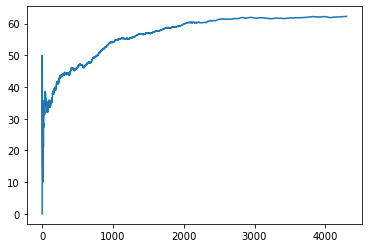

In [87]:
plt.plot(fraction)
plt.show()

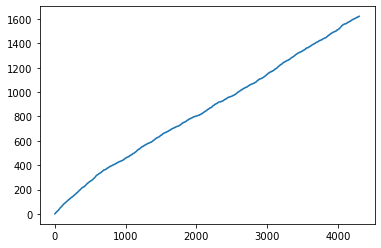

In [84]:
plt.plot(regret)
plt.show()

#### Lin UCB with poly features

In [52]:
warpoly2 = warpoly.drop(['1'], axis=1)

In [54]:
# LinUCB, single run, polynomial features
m, n = warpoly2.shape
delta = 0.005
alpha = 1 + np.sqrt(np.log(2/delta)/2)
dosage = ['Low', 'Medium', 'High']
fraction = np.zeros(m)
regret = np.zeros(m)
#print(fraction.shape, regret)
totalReward = 0
totalCorrect = 0
np.random.seed(0)
indices = np.arange(m)
np.random.shuffle(indices)
count = 0
A1, A2, A3 = np.eye(n), np.eye(n), np.eye(n)
b1, b2, b3 = np.zeros((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))
for i in indices:
    count += 1
    correct_pred = true_pred.iloc[i]
    # get feature vector
    row = warpoly2.iloc[i, :].values
    row = row[:, np.newaxis]
    # calculate arm 'strengths'
    A1inv, A2inv, A3inv = np.linalg.inv(A1),np.linalg.inv(A2), np.linalg.inv(A3)
    theta1 = np.matmul(A1inv, b1)
    theta2 = np.matmul(A2inv, b2)
    theta3 = np.matmul(A3inv, b3)
    val1 = theta1.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A1inv, row))) 
    val2 = theta2.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A2inv, row)))
    val3 = theta3.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A3inv, row)))
    # choose arm
    j = np.argmax([val1, val2, val3])
    armChosen = dosage[j]
    # reward
    if armChosen==correct_pred:
        r = 0
        totalCorrect += 1
    else:
        r = -1
    # Update A, b
    if j==0:
        A1 += np.matmul(row,row.T)
        b1 += r*row
    elif j==1:
        A2 += np.matmul(row,row.T)
        b2 += r*row
    else:
        A3 += np.matmul(row,row.T)
        b3 += r*row
    totalReward += r
    #print(k, count-1)
    regret[count-1] = totalReward*-1
    fraction[count-1] = totalCorrect*100.0/count

In [55]:
fraction[-1]

62.28784003720065

In [56]:
regret[-1]

1622.0

In [48]:
regretUCBpoly, fractionUCBpoly = regret, fraction

#### Lin UCB with std features

In [49]:
# LinUCB, single run
m, n = warnearin.shape
delta = 0.005
alpha = 1 + np.sqrt(np.log(2/delta)/2)
dosage = ['Low', 'Medium', 'High']
fraction = np.zeros(m)
regret = np.zeros(m)
#print(fraction.shape, regret)
totalReward = 0
totalCorrect = 0
np.random.seed(0)
indices = np.arange(m)
np.random.shuffle(indices)
count = 0
A1, A2, A3 = np.eye(n), np.eye(n), np.eye(n)
b1, b2, b3 = np.zeros((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))
for i in indices:
    count += 1
    correct_pred = true_pred.iloc[i]
    # get feature vector
    row = warnearin.iloc[i, :].values
    row = row[:, np.newaxis]
    # calculate arm 'strengths'
    A1inv, A2inv, A3inv = np.linalg.inv(A1),np.linalg.inv(A2), np.linalg.inv(A3)
    theta1 = np.matmul(A1inv, b1)
    theta2 = np.matmul(A2inv, b2)
    theta3 = np.matmul(A3inv, b3)
    val1 = theta1.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A1inv, row))) 
    val2 = theta2.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A2inv, row)))
    val3 = theta3.T.dot(row)+alpha*np.sqrt(np.matmul(row.T, np.matmul(A3inv, row)))
    # choose arm
    j = np.argmax([val1, val2, val3])
    armChosen = dosage[j]
    # reward
    if armChosen==correct_pred:
        r = 0
        totalCorrect += 1
    else:
        r = -1
    # Update A, b
    if j==0:
        A1 += np.matmul(row,row.T)
        b1 += r*row
    elif j==1:
        A2 += np.matmul(row,row.T)
        b2 += r*row
    else:
        A3 += np.matmul(row,row.T)
        b3 += r*row
    totalReward += r
    #print(k, count-1)
    regret[count-1] = totalReward*-1
    fraction[count-1] = totalCorrect*100.0/count

In [50]:
fraction[-1]

64.33387584282725

In [51]:
regret[-1]

1534.0

In [53]:
regretUCB, fractionUCB = regret, fraction

# Real rewards

In [96]:
true_pred_real = warnearout.to_numpy()

In [97]:
true_pred_real.shape

(4301,)

In [143]:
fractionReal[-1]

65.9846547314578

In [144]:
cf = confusion_matrix(true_pred, armChosen, labels=['Low', 'Medium', 'High'], normalize='all')
cf

array([[0.09253662, 0.1655429 , 0.        ],
       [0.05184841, 0.56661242, 0.00116252],
       [0.00139502, 0.1202046 , 0.00069751]])